# 导入模块

In [92]:
import joblib
import warnings
import numpy as np
import pandas as pd
from typing import List
import statsmodels.api as sm
import matplotlib.pyplot as plt
from skopt import BayesSearchCV
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc

warnings.filterwarnings("ignore")
pd.set_option("display.width", 10000)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
plt.rcParams['font.sans-serif'] = ['FangSong']
plt.rcParams['axes.unicode_minus'] = False
plt.style.use("Solarize_Light2")

# 加载数据

| 字段名           | 类型    | 枚举值个数 | 说明                                                 |
| ---------------- | ------- | ---------- | ---------------------------------------------------- |
| id               | int64   | 22500      | 客户ID                                               |
| age              | int64   | 86         | 年龄                                                 |
| job              | object  | 12         | 职业：admin, unknown, unemployed, management         |
| marital          | object  | 4          | 婚姻：married, divorced, single                      |
| education        | object  | 8          | 教育水平                                             |
| default          | object  | 3          | 信用卡是否有违约: yes or no                          |
| housing          | object  | 3          | 是否有房贷: yes or no                                |
| loan             | object  | 3          | 是否有贷款：yes、no、unknown                         |
| contact          | object  | 2          | 联系方式：unknown, telephone, cellular               |
| month            | object  | 10         | 上一次联系的月份：jan, feb, mar, …                   |
| day_of_week      | object  | 5          | 上一次联系的星期几：mon, tue, wed, thu, fri          |
| duration         | int64   | 4385       | 上一次联系的时长（秒）                               |
| campaign         | int64   | 58         | 活动期间联系客户的次数                               |
| pdays            | int64   | 1049       | 上一次与客户联系后的间隔天数                         |
| previous         | int64   | 7          | 在本次营销活动前，与客户联系的次数                   |
| poutcome         | object  | 3          | 之前营销活动的结果：unknown, other, failure, success |
| emp_var_rate     | float64 | 10         | 就业变动率（季度指标）                               |
| cons_price_index | float64 | 1151       | 消费者价格指数（月度指标）                           |
| cons_conf_index  | float64 | 2603       | 消费者信心指数（月度指标）                           |
| lending_rate3m   | float64 | 467        | 银行同业拆借率 3个月利率（每日指标）                 |
| nr_employed      | float64 | 9285       | 雇员人数（季度指标）                                 |
| subscribe        | object  | 2          | 客户是否进行购买：yes 或 no                          |

In [2]:
train = pd.read_csv("../dataset/train.csv")
train.head()

,id,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_index,cons_conf_index,lending_rate3m,nr_employed,subscribe
0,1,51,admin.,divorced,professional.course,no,yes,yes,cellular,aug,mon,4621,1,112,2,failure,1.4,90.81,-35.53,0.69,5219.74,no
1,2,50,services,married,high.school,unknown,yes,no,cellular,may,mon,4715,1,412,2,nonexistent,-1.8,96.33,-40.58,4.05,4974.79,yes
2,3,48,blue-collar,divorced,basic.9y,no,no,no,cellular,apr,wed,171,0,1027,1,failure,-1.8,96.33,-44.74,1.50,5022.61,no
3,4,26,entrepreneur,single,high.school,yes,yes,yes,cellular,aug,fri,359,26,998,0,nonexistent,1.4,97.08,-35.55,5.11,5222.87,yes
4,5,45,admin.,single,university.degree,no,no,no,cellular,nov,tue,3178,1,240,4,success,-3.4,89.82,-33.83,1.17,4884.70,no


# 数据探索

## 查看数据类型

In [3]:
train.dtypes

id                    int64
age                   int64
job                  object
marital              object
education            object
default              object
housing              object
loan                 object
contact              object
month                object
day_of_week          object
duration              int64
campaign              int64
pdays                 int64
previous              int64
poutcome             object
emp_var_rate        float64
cons_price_index    float64
cons_conf_index     float64
lending_rate3m      float64
nr_employed         float64
subscribe            object
dtype: object

## 查看缺失率

In [4]:
train.isnull().sum() / train.shape[0]

id                  0.0
age                 0.0
job                 0.0
marital             0.0
education           0.0
default             0.0
housing             0.0
loan                0.0
contact             0.0
month               0.0
day_of_week         0.0
duration            0.0
campaign            0.0
pdays               0.0
previous            0.0
poutcome            0.0
emp_var_rate        0.0
cons_price_index    0.0
cons_conf_index     0.0
lending_rate3m      0.0
nr_employed         0.0
subscribe           0.0
dtype: float64

## 查看字段唯一值

In [5]:
train.nunique()

id                  22500
age                    86
job                    12
marital                 4
education               8
default                 3
housing                 3
loan                    3
contact                 2
month                  10
day_of_week             5
duration             4385
campaign               58
pdays                1049
previous                7
poutcome                3
emp_var_rate           10
cons_price_index     1151
cons_conf_index      2603
lending_rate3m        467
nr_employed          9285
subscribe               2
dtype: int64

## 特征分布

In [6]:
def bar_graph_plot(horiz_df: List, 
                   long_df: List, 
                   xlabel: str = "x",
                   ylabel: str = "数值",
                   width: float = 0.8,
                   color: str = '#44C84E',
                   linewidth: int = 2,
                   align: str = 'center', 
                   edgecolor: str = '#9F59D6', 
                   label: str = None, 
                   fontsize=14,
                   dpi: int = 300,
                   rotation=0,
                   figsize=(8,6), 
                   file=None):
    # 设置图形大小
    fig = plt.figure(figsize=figsize, facecolor='none', edgecolor='none')
    
    # 绘制柱状图
    bars = plt.bar(x=horiz_df, 
                   height=long_df, 
                   width=width, 
                   color=color, 
                   linewidth=linewidth, 
                   edgecolor=edgecolor, 
                   label=label, 
                   align=align)
    
    # 设置坐标轴
    plt.xlabel(xlabel, fontsize=fontsize, weight="bold")
    plt.ylabel(ylabel, fontsize=fontsize)
    plt.xticks(fontsize=fontsize, fontweight="bold", rotation=rotation)
    plt.yticks(fontsize=fontsize)
    
    # 显示图例
    if label:
        plt.legend(fontsize=fontsize)
    
    # 设置显示数据
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x()+bar.get_width()/2, height, str(height), ha='center', va='bottom', fontsize=fontsize)
        plt.text(bar.get_x()+bar.get_width()/2, height/2, f"{height/sum(y):.2%}", ha='center', va='bottom', fontsize=fontsize)
    
    # 设置图形边缘空白最小
    fig.patch.set_alpha(0.0)
    
    if file:
        plt.savefig(file, dpi=dpi, bbox_inches='tight')
    
    return plt


def numeric_distplot(num_data, file=None, bins=30, color='lime', fontsize=14, label='Label', dpi=500, figsize=(8,6)):
    # 设置图形大小
    fig = plt.figure(figsize=figsize, facecolor='none', edgecolor='none')
    
    # 绘制分布图
    dist = plt.hist(num_data, bins=bins, edgecolor='black', color=color, density=True, label=label)
    
    # 设置坐标轴标题和添加图例
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.xlabel("VALUE", fontsize=fontsize)
    plt.ylabel("frequency", fontsize=fontsize)
    plt.legend(fontsize=fontsize)
    
    # 设置图形边缘空白最小化
    fig.patch.set_alpha(0.0)
    
    # 是否保存图片
    if file:
        plt.savefig(file, dpi=dpi, bbox_inches='tight')
    
    return plt

def circle_plot(labels, sizes, inner_radius=0.4):
    length = len(labels)
    colors = ['#009E56', '#D02691', '#007EB1', '#7E3F98', '#F53737', '#1B3F91', '#009393', '#44C84E', '#E17A1D', '#784101'][:length]
    
    # 设置图形大小
    fig = plt.figure(figsize=(5, 4), facecolor='none', edgecolor='none')
    
    # 绘制环形图
    fig, ax = plt.subplots()
    ax.pie(sizes, labels=labels, colors=colors, autopct='%1.2f%%', startangle=90, textprops=dict(fontsize=14, color='k'))  # 绘制外圈
    ax.axis('equal')
    
    center_circle = plt.Circle((0, 0), inner_radius, color='white')  # 绘制内圈
    ax.add_artist(center_circle)
    

    # 设置图形边缘空白最小化
    fig.patch.set_alpha(0.0)
    
    return plt

### 目标分布

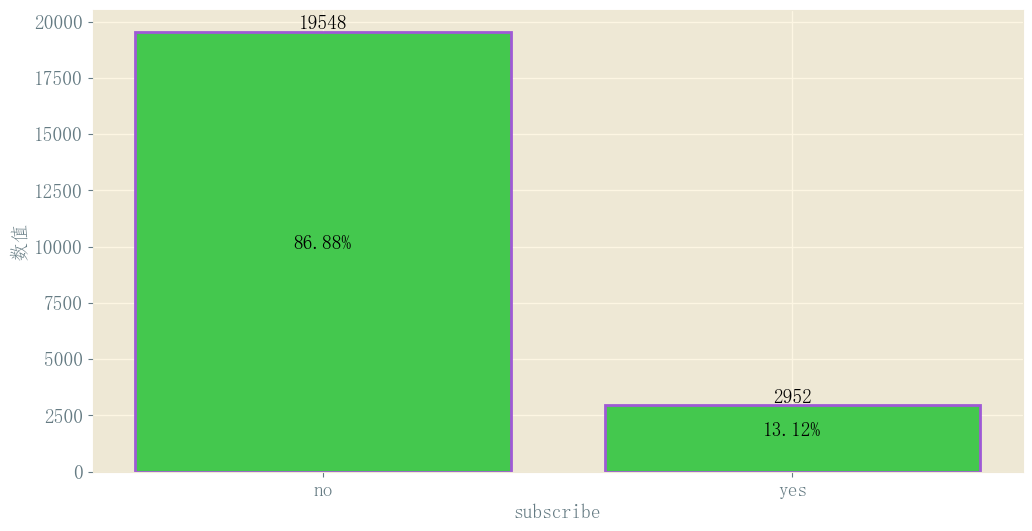

In [8]:
# 数据
res = train['subscribe'].value_counts().reset_index()
x, y = res['index'].tolist(), res['subscribe'].tolist()
plt = bar_graph_plot(x, y, xlabel="subscribe", file="../figures/001_目标分布.png", dpi=500, figsize=(12, 6))
plt.show()

### 职业分布

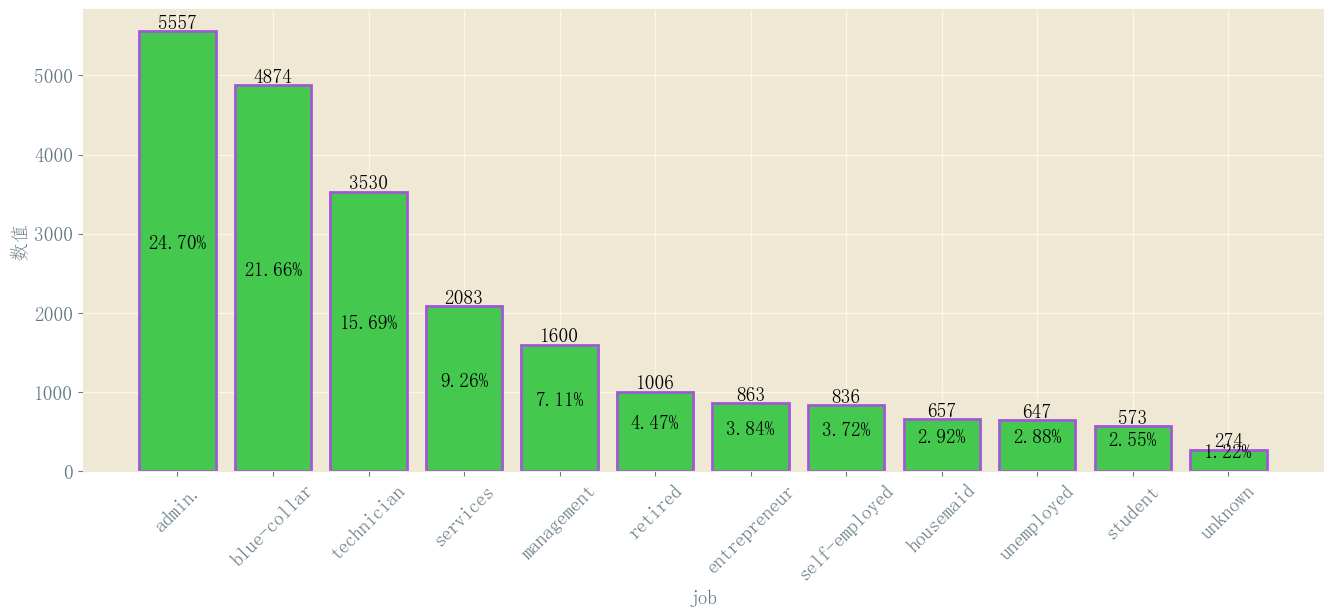

In [9]:
res = train['job'].value_counts().reset_index()
x, y = res['index'].tolist(), res['job'].tolist()
plt = bar_graph_plot(x, y, xlabel="job", file="../figures/001_职业分布.png", dpi=500, figsize=(16,6), rotation=45)
plt.show()

### 婚姻分布

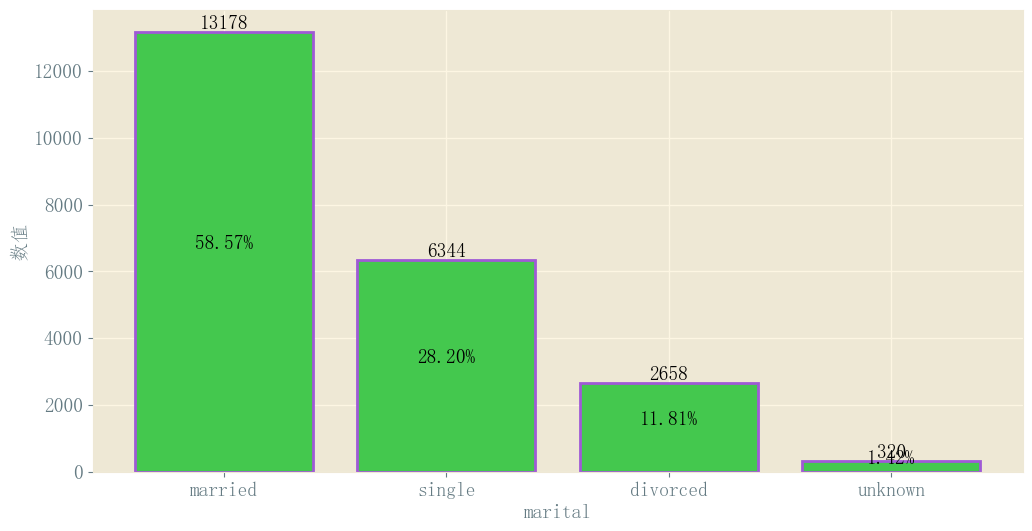

In [10]:
res = train['marital'].value_counts().reset_index()
x, y = res['index'].tolist(), res['marital'].tolist()
plt = bar_graph_plot(x, y, xlabel="marital", file="../figures/001_婚姻分布.png", dpi=500, figsize=(12,6), rotation=0)
plt.show()

### 教育水平分布

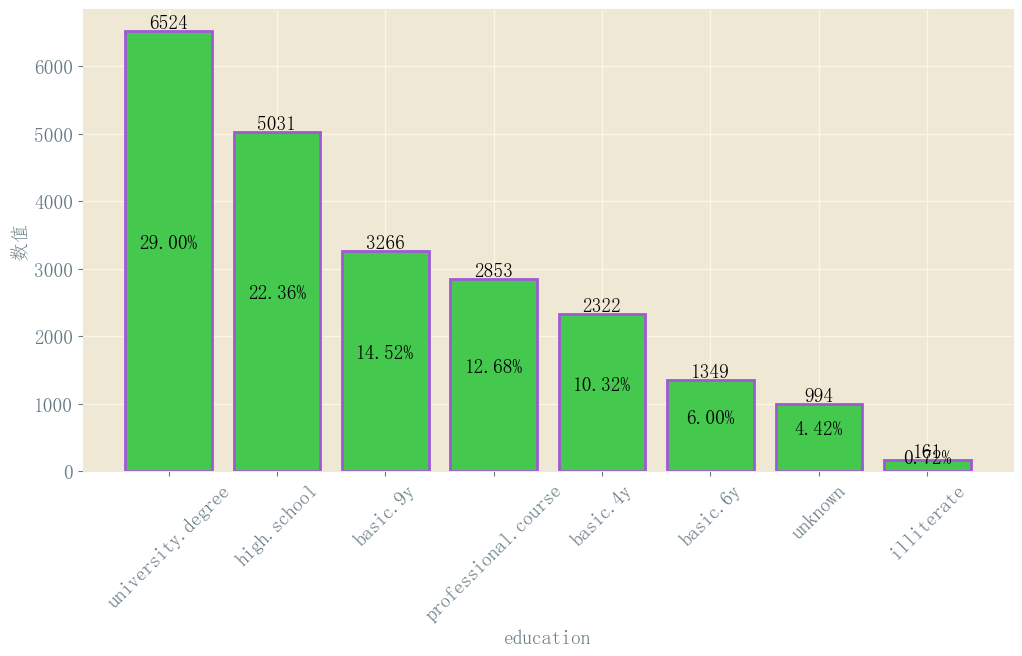

In [11]:
res = train['education'].value_counts().reset_index()
x, y = res['index'].tolist(), res['education'].tolist()
plt = bar_graph_plot(x, y, xlabel="education", file="../figures/001_教育水平分布.png", dpi=500, figsize=(12,6), rotation=45)
plt.show()

### 信用卡是否有违约分布

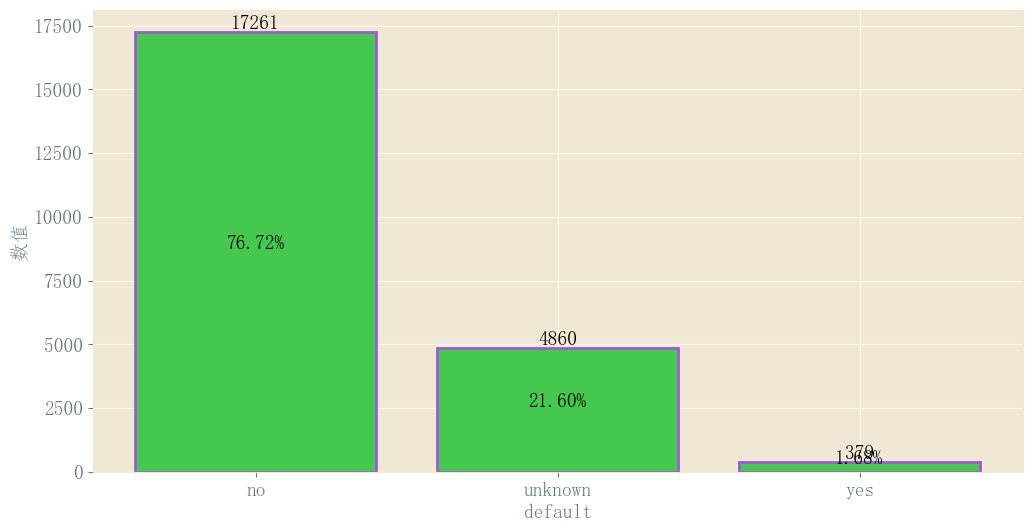

In [13]:
res = train['default'].value_counts().reset_index()
x, y = res['index'].tolist(), res['default'].tolist()
plt = bar_graph_plot(x, y, xlabel="default", file="../figures/001_信用卡是否有违约分布.png", dpi=500, figsize=(12,6), rotation=0)
plt.show()

### 是否有房贷分布

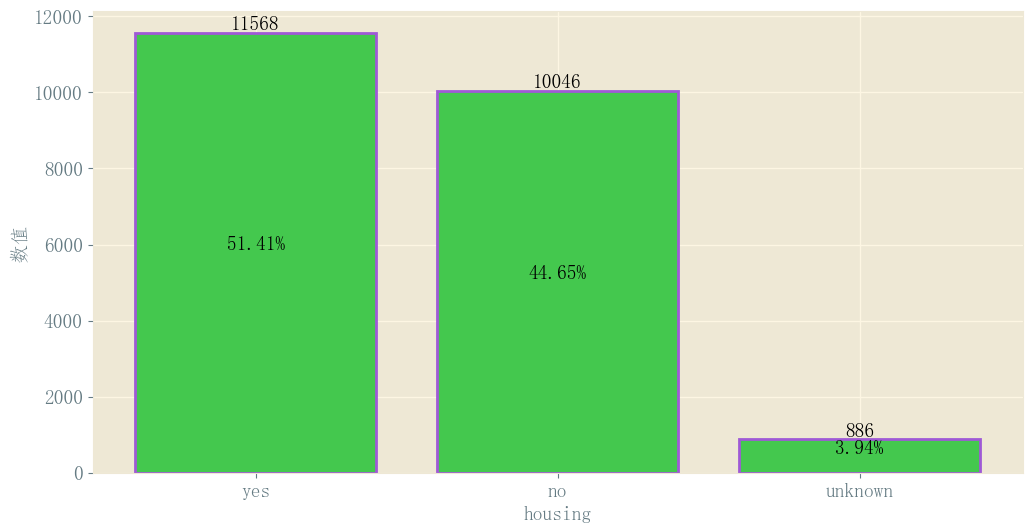

In [14]:
res = train['housing'].value_counts().reset_index()
x, y = res['index'].tolist(), res['housing'].tolist()
plt = bar_graph_plot(x, y, xlabel="housing", file="../figures/001_是否有房贷分布.png", dpi=500, figsize=(12,6), rotation=0)
plt.show()

### 是否有贷款分布

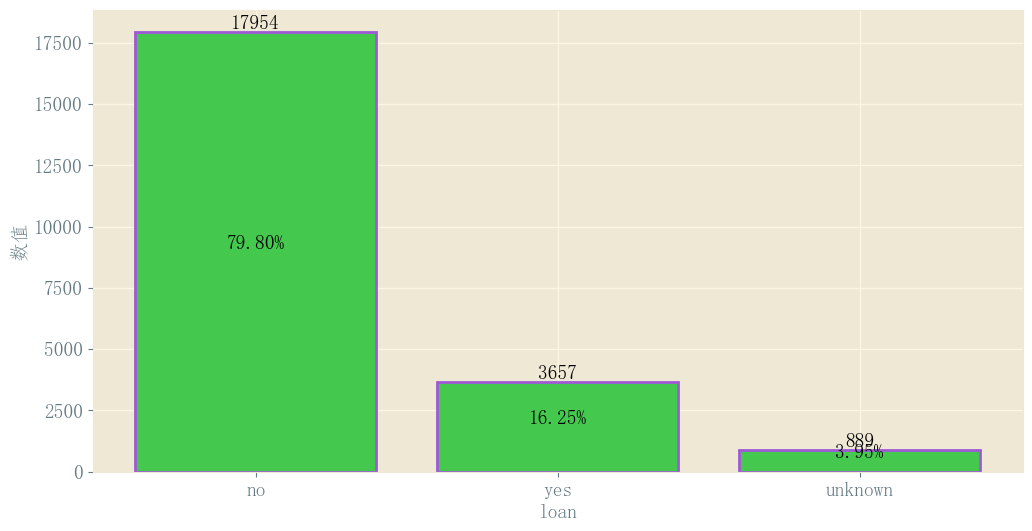

In [15]:
res = train['loan'].value_counts().reset_index()
x, y = res['index'].tolist(), res['loan'].tolist()
plt = bar_graph_plot(x, y, xlabel="loan", file="../figures/001_是否有贷款分布.png", dpi=500, figsize=(12,6), rotation=0)
plt.show()

### 联系方式分布

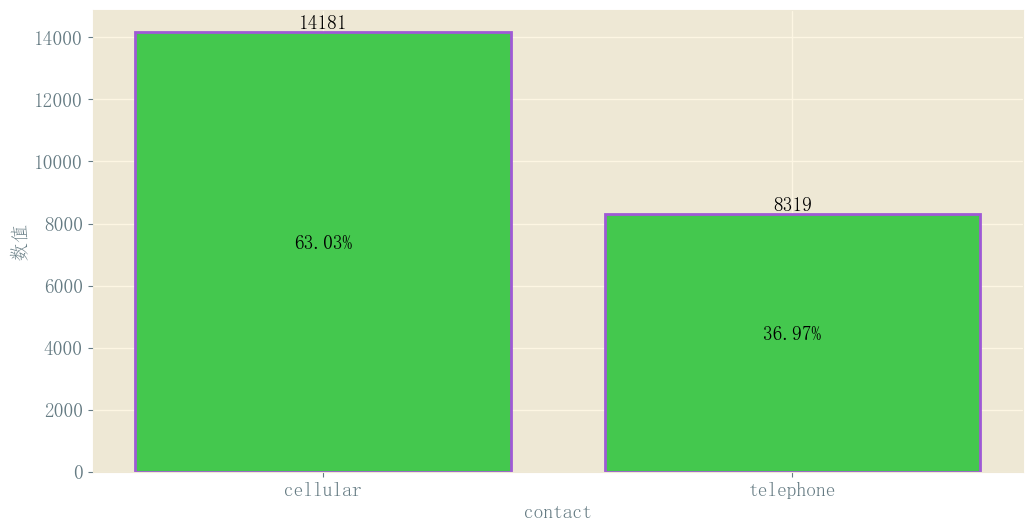

In [16]:
res = train['contact'].value_counts().reset_index()
x, y = res['index'].tolist(), res['contact'].tolist()
plt = bar_graph_plot(x, y, xlabel="contact", file="../figures/001_联系方式分布.png", dpi=500, figsize=(12,6), rotation=0)
plt.show()

### 上一次联系的月份分布

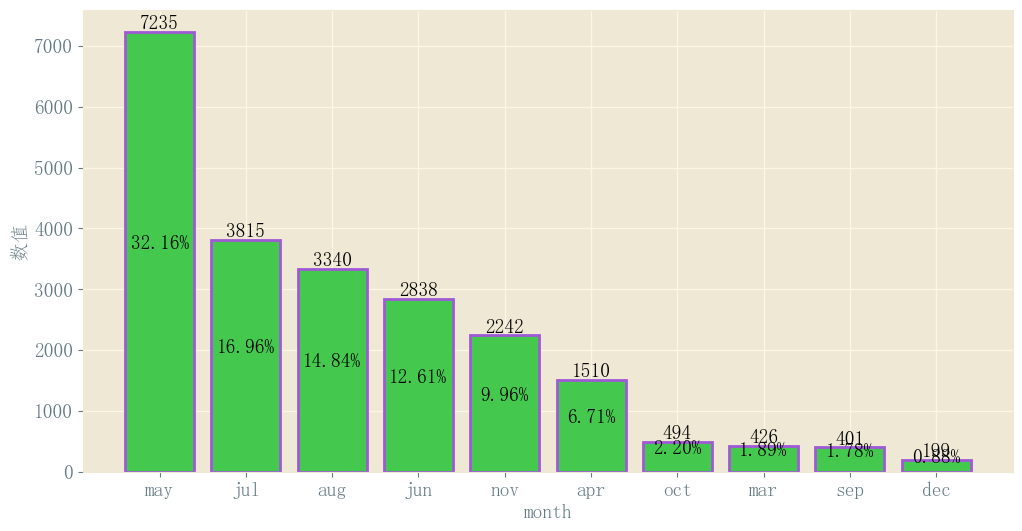

In [17]:
res = train['month'].value_counts().reset_index()
x, y = res['index'].tolist(), res['month'].tolist()
plt = bar_graph_plot(x, y, xlabel="month", file="../figures/001_上一次联系的月份分布.png", dpi=500, figsize=(12,6), rotation=0)
plt.show()

### 上一次联系的星期几分布

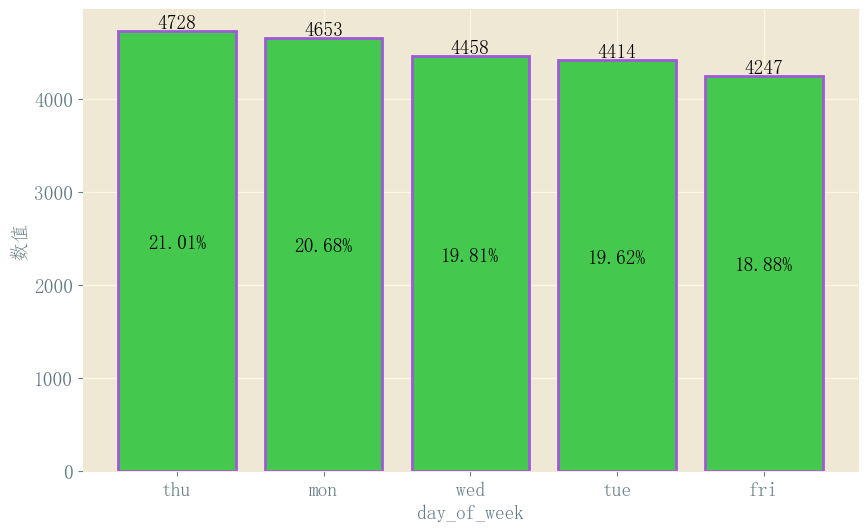

In [18]:
res = train['day_of_week'].value_counts().reset_index()
x, y = res['index'].tolist(), res['day_of_week'].tolist()
plt = bar_graph_plot(x, y, xlabel="day_of_week", file="../figures/001_上一次联系的星期几分布.png", dpi=500, figsize=(10,6), rotation=0)
plt.show()

### 之前营销活动的结果分布

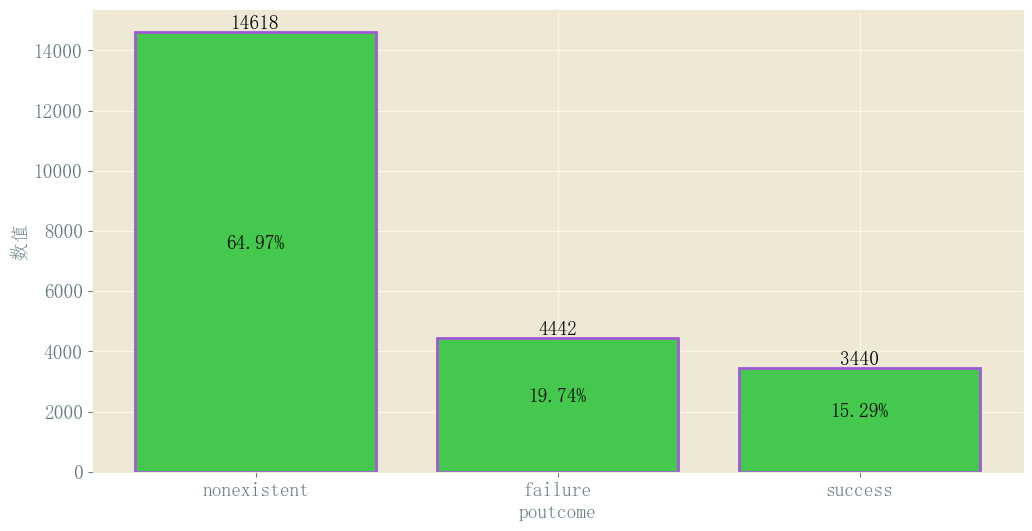

In [19]:
res = train['poutcome'].value_counts().reset_index()
x, y = res['index'].tolist(), res['poutcome'].tolist()
plt = bar_graph_plot(x, y, xlabel="poutcome", file="../figures/001_之前营销活动的结果分布.png", dpi=500, figsize=(12,6), rotation=0)
plt.show()

### 年龄分布

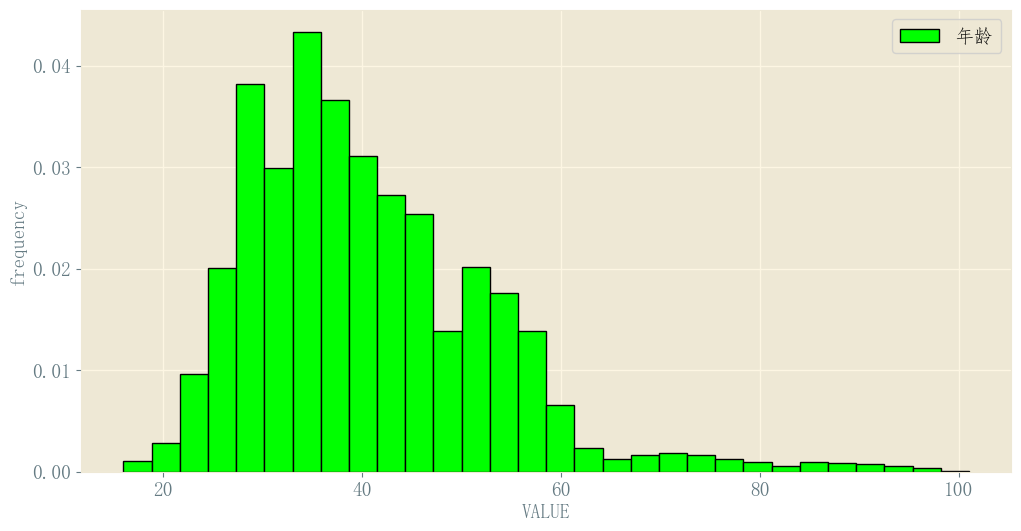

In [20]:
plt = numeric_distplot(train['age'], label="年龄", file="../figures/002_年龄分布.png", figsize=(12,6))
plt.show()

### 上一次联系的时长分布

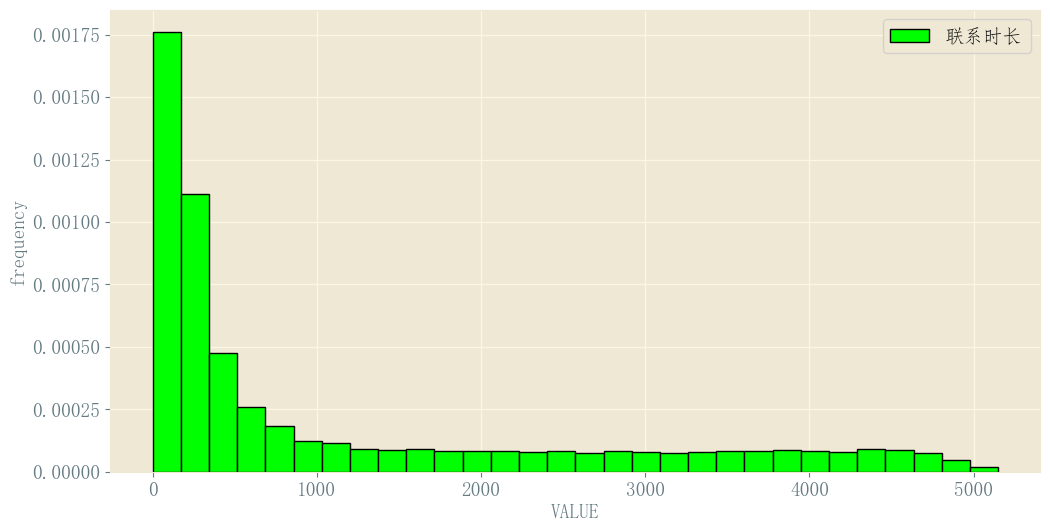

In [21]:
plt = numeric_distplot(train['duration'], label="联系时长", file="../figures/002_上一次联系的时长分布.png", figsize=(12,6))
plt.show()

### 活动期间联系客户的次数分布

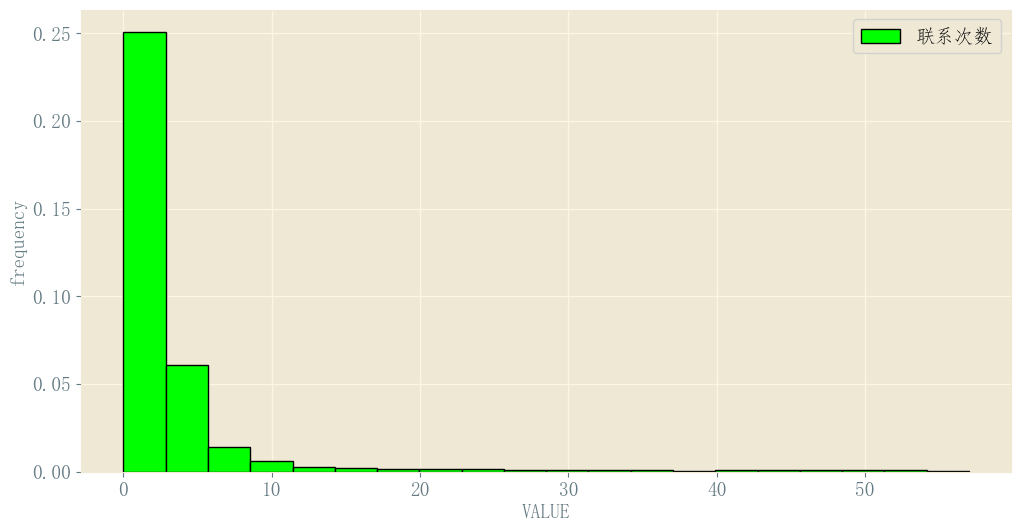

In [22]:
plt = numeric_distplot(train['campaign'], bins=20, label="联系次数", file="../figures/002_活动期间联系客户的次数分布.png", figsize=(12,6))
plt.show()

### 上一次与客户联系后的间隔天数分布

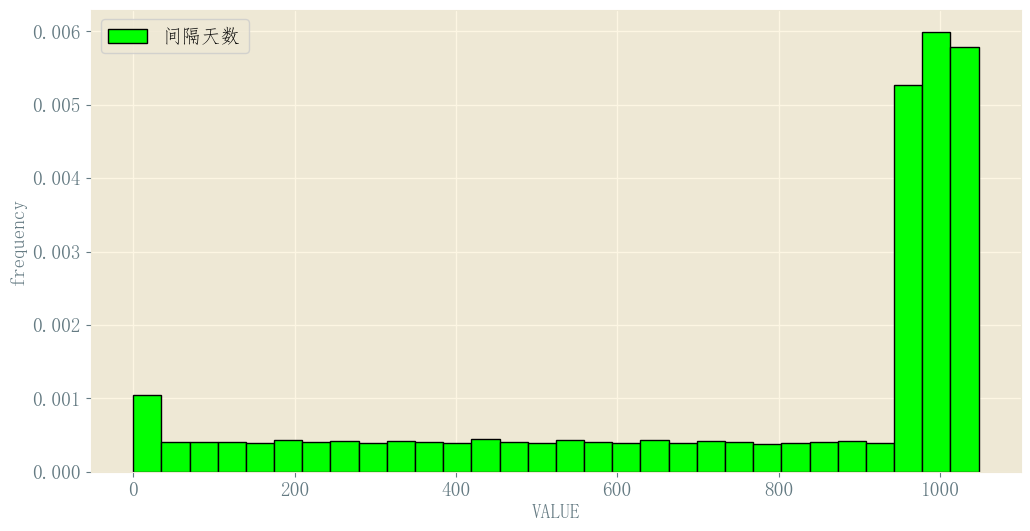

In [23]:
plt = numeric_distplot(train['pdays'], label="间隔天数", file="../figures/002_上一次与客户联系后的间隔天数分布.png", figsize=(12,6))
plt.show()

### 客户联系的次数分布

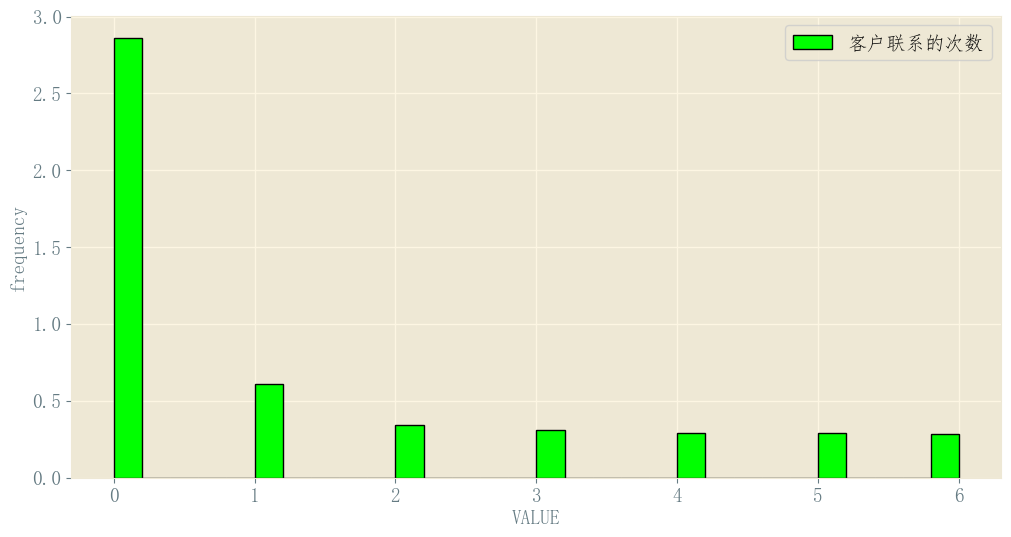

In [25]:
plt = numeric_distplot(train['previous'], label="客户联系的次数", file="../figures/002_客户联系的次数分布.png", figsize=(12,6))
plt.show()

### 就业变动率

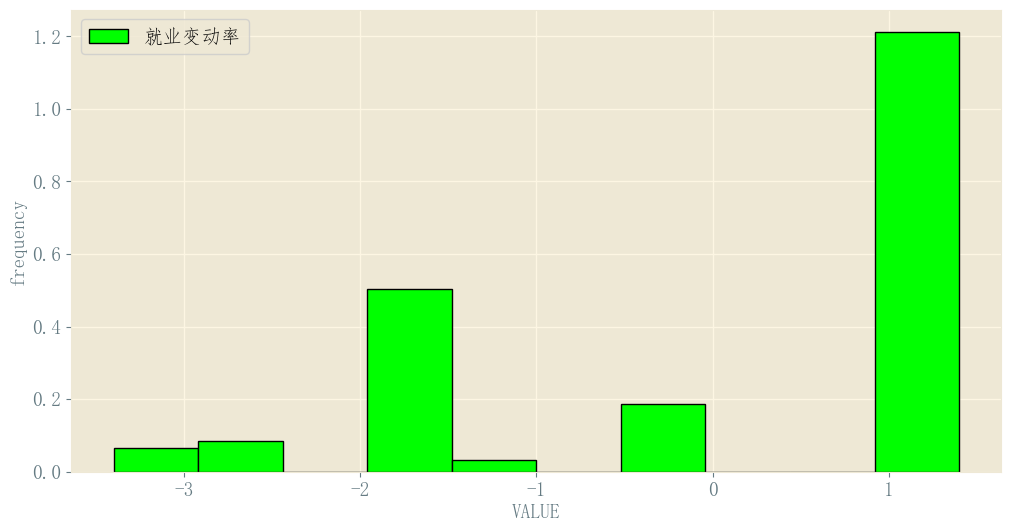

In [26]:
plt = numeric_distplot(train['emp_var_rate'], bins=None, label="就业变动率", file="../figures/002_就业变动率分布.png", figsize=(12,6))
plt.show()

### 消费者价格指数分布

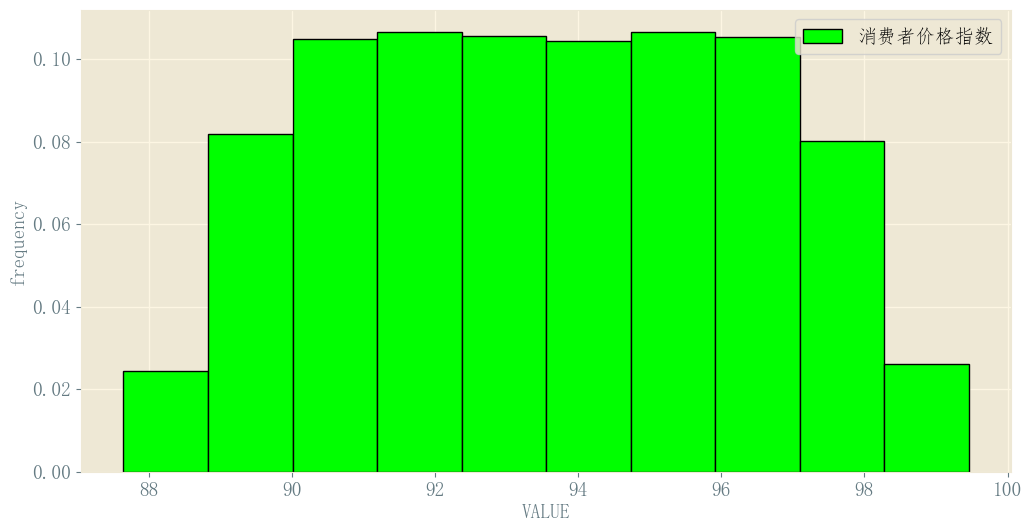

In [27]:
plt = numeric_distplot(train['cons_price_index'], bins=None, label="消费者价格指数", file="../figures/002_消费者价格指数分布.png", figsize=(12,6))
plt.show()

### 消费者信心指数分布

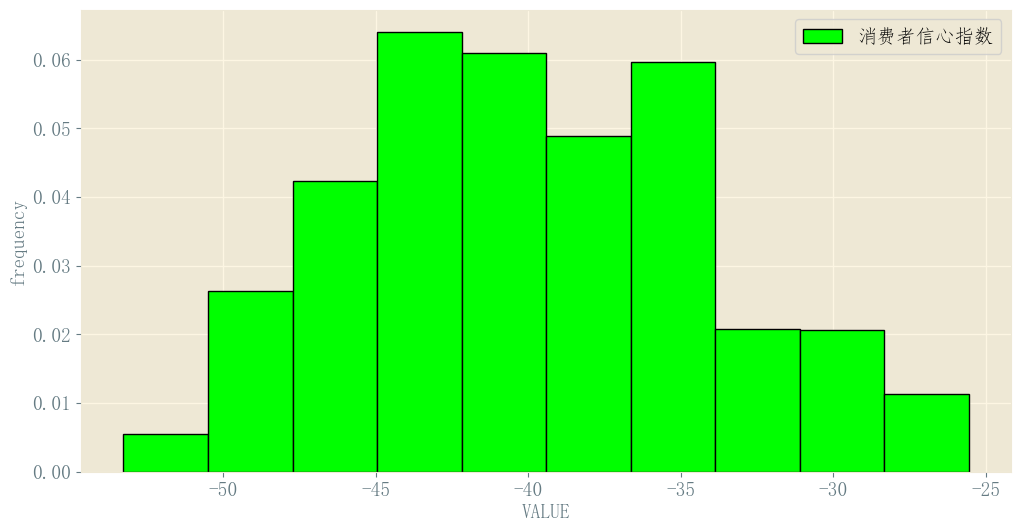

In [28]:
plt = numeric_distplot(train['cons_conf_index'], bins=None, label="消费者信心指数", file="../figures/002_消费者信心指数分布.png", figsize=(12,6))
plt.show()

### 银行同业拆借率3个月利率分布

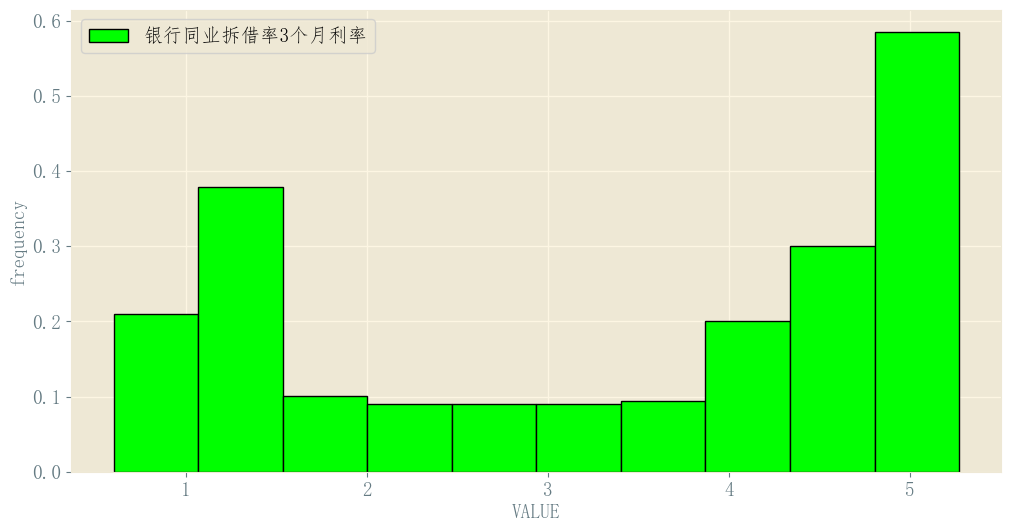

In [29]:
plt = numeric_distplot(train['lending_rate3m'], bins=None, label="银行同业拆借率3个月利率", file="../figures/002_银行同业拆借率3个月利率分布.png", figsize=(12,6))
plt.show()

### 雇员人数

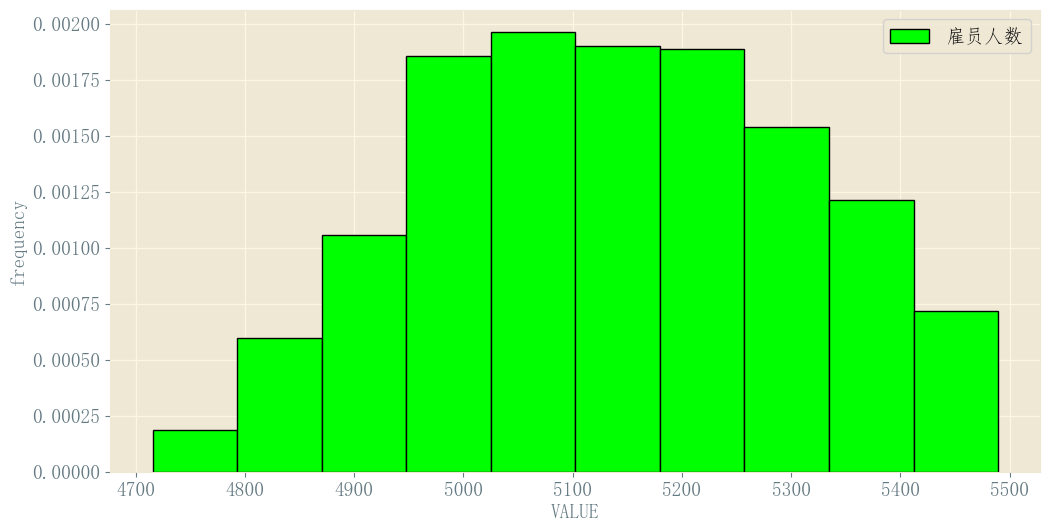

In [30]:
plt = numeric_distplot(train['nr_employed'], bins=None, label="雇员人数", file="../figures/002_雇员人数分布.png", figsize=(12,6))
plt.show()

## 画像分布

In [31]:
def bar_graph_plot(horiz_df: List, 
                   long_df: List, 
                   xlabel: str = "x",
                   ylabel: str = "正样本占比",
                   width: float = 0.8,
                   color: str = '#44C84E',
                   linewidth: int = 2,
                   align: str = 'center', 
                   edgecolor: str = '#9F59D6', 
                   label: str = None, 
                   fontsize=14,
                   dpi: int = 300,
                   rotation=0,
                   figsize=(12,6), 
                   file=None):
    # 设置图形大小
    fig = plt.figure(figsize=figsize, facecolor='none', edgecolor='none')
    
    # 绘制柱状图
    bars = plt.bar(x=horiz_df, 
                   height=long_df, 
                   width=width, 
                   color=color, 
                   linewidth=linewidth, 
                   edgecolor=edgecolor, 
                   label=label, 
                   align=align)
    
    # 设置坐标轴
    plt.xlabel(xlabel, fontsize=fontsize, weight="bold")
    plt.ylabel(ylabel, fontsize=fontsize)
    plt.xticks(fontsize=fontsize, fontweight="bold", rotation=rotation)
    plt.yticks(fontsize=fontsize)
    
    # 显示图例
    if label:
        plt.legend(fontsize=fontsize)
    
    # 设置显示数据
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x()+bar.get_width()/2, height, f"{height:.2%}", ha='center', va='bottom', fontsize=fontsize)
    
    # 设置图形边缘空白最小
    fig.patch.set_alpha(0.0)
    
    if file:
        plt.savefig(file, dpi=dpi, bbox_inches='tight')
    
    return plt

In [32]:
train["LABEL"] = train["subscribe"].apply(lambda x: 1 if x == "yes" else 0)

### 职业分布

In [33]:
res = train.groupby(by='job').agg(func={"id": "count", "LABEL": "sum"}).reset_index()
res.columns = ["职业", "样本数", "正样本数"]
res["正样本率"] = (res["正样本数"] / res["样本数"]).round(4)
res.sort_values(by='正样本率', ascending=False)

,职业,样本数,正样本数,正样本率
8,student,573,189,0.3298
5,retired,1006,272,0.2704
11,unknown,274,71,0.2591
10,unemployed,647,131,0.2025
6,self-employed,836,137,0.1639
3,housemaid,657,98,0.1492
4,management,1600,217,0.1356
0,admin.,5557,730,0.1314
2,entrepreneur,863,106,0.1228
9,technician,3530,432,0.1224


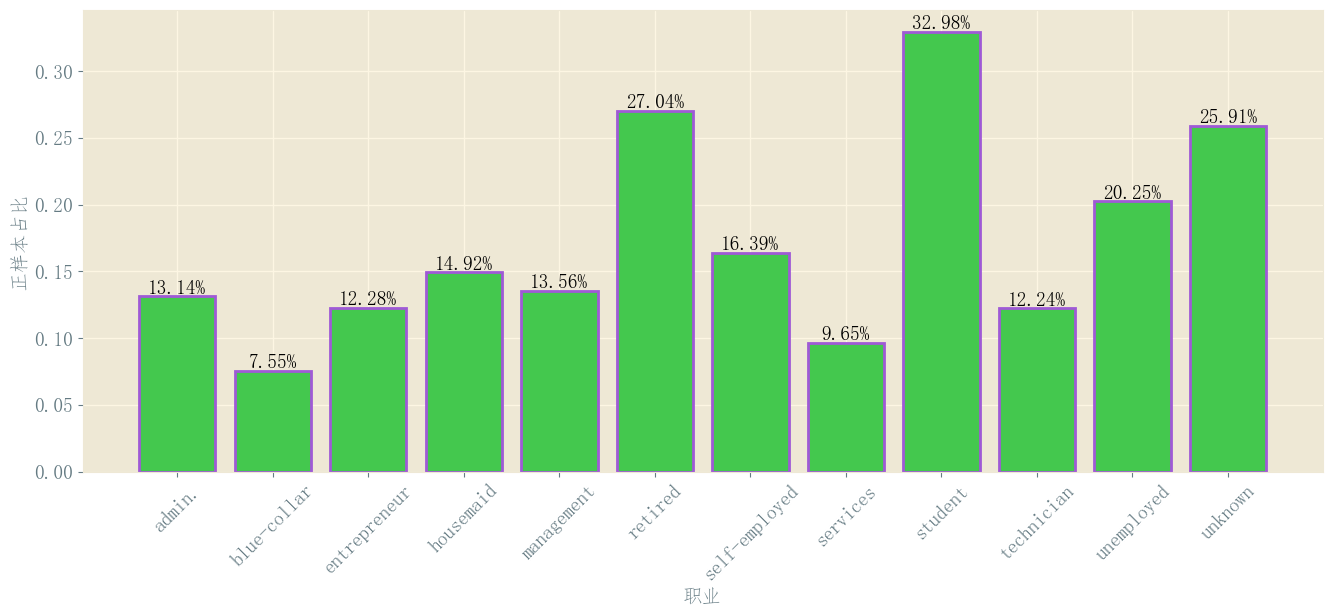

In [34]:
x, y = res['职业'].tolist(), res['正样本率'].tolist()
plt = bar_graph_plot(x, y, xlabel="职业", file="../figures/003_职业正样本分布.png", dpi=500, figsize=(16,6), rotation=45)
plt.show()

### 婚姻分布

In [35]:
res = train.groupby(by='marital').agg(func={"id": "count", "LABEL": "sum"}).reset_index()
res.columns = ["婚姻状况", "样本数", "正样本数"]
res["正样本率"] = (res["正样本数"] / res["样本数"]).round(4)
res.sort_values(by='正样本率', ascending=False)

,婚姻状况,样本数,正样本数,正样本率
3,unknown,320,146,0.4562
2,single,6344,1043,0.1644
0,divorced,2658,352,0.1324
1,married,13178,1411,0.1071


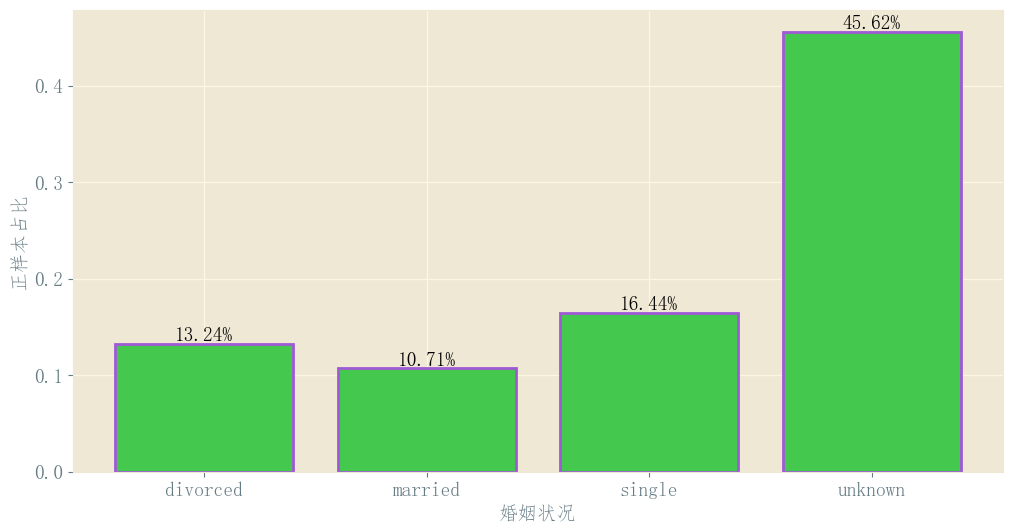

In [36]:
x, y = res['婚姻状况'].tolist(), res['正样本率'].tolist()
plt = bar_graph_plot(x, y, xlabel="婚姻状况", file="../figures/003_婚姻正样本分布.png", dpi=500, figsize=(12,6), rotation=0)
plt.show()

### 教育水平分布

In [37]:
res = train.groupby(by='education').agg(func={"id": "count", "LABEL": "sum"}).reset_index()
res.columns = ["教育水平", "样本数", "正样本数"]
res["正样本率"] = (res["正样本数"] / res["样本数"]).round(4)
res.sort_values(by='正样本率', ascending=False)

,教育水平,样本数,正样本数,正样本率
4,illiterate,161,81,0.5031
7,unknown,994,181,0.1821
6,university.degree,6524,961,0.1473
5,professional.course,2853,391,0.1370
1,basic.6y,1349,164,0.1216
0,basic.4y,2322,282,0.1214
3,high.school,5031,587,0.1167
2,basic.9y,3266,305,0.0934


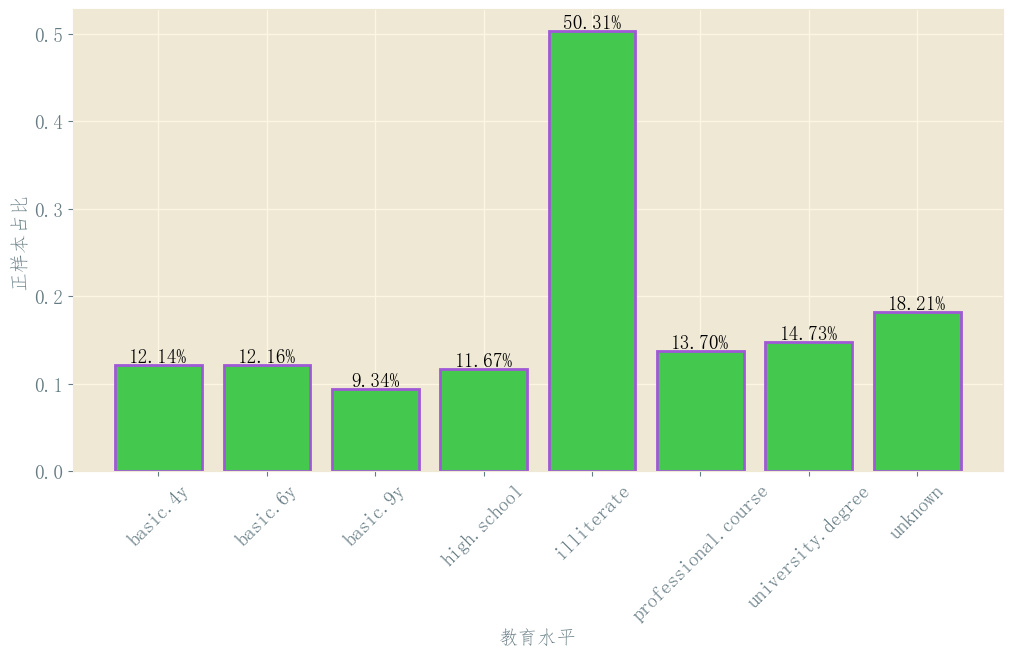

In [38]:
x, y = res['教育水平'].tolist(), res['正样本率'].tolist()
plt = bar_graph_plot(x, y, xlabel="教育水平", file="../figures/003_教育水平正样本分布.png", dpi=500, figsize=(12,6), rotation=45)
plt.show()

### 信用卡是否有违约分布

In [39]:
res = train.groupby(by='default').agg(func={"id": "count", "LABEL": "sum"}).reset_index()
res.columns = ["信用卡违约", "样本数", "正样本数"]
res["正样本率"] = (res["正样本数"] / res["样本数"]).round(4)
res.sort_values(by='正样本率', ascending=False)

,信用卡违约,样本数,正样本数,正样本率
2,yes,379,199,0.5251
0,no,17261,2349,0.1361
1,unknown,4860,404,0.0831


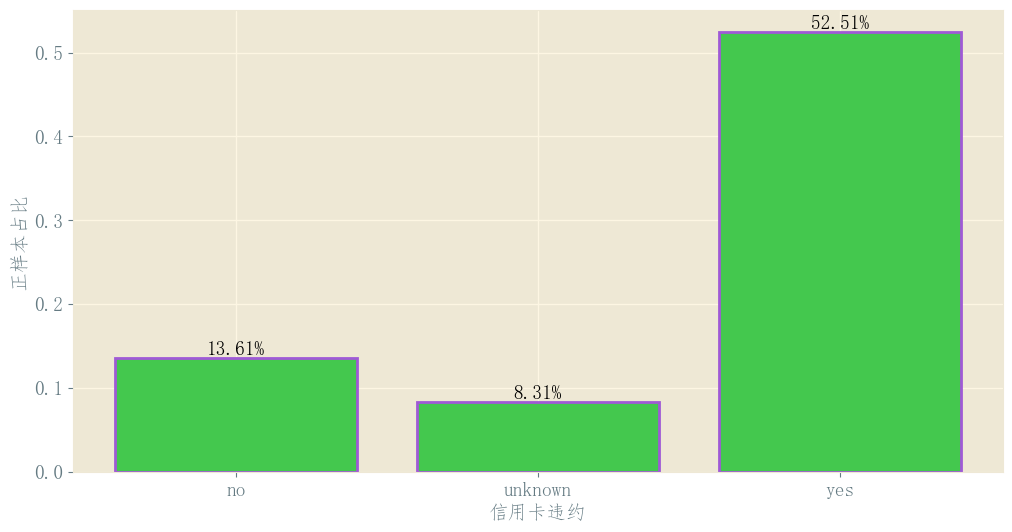

In [40]:
x, y = res['信用卡违约'].tolist(), res['正样本率'].tolist()
plt = bar_graph_plot(x, y, xlabel="信用卡违约", file="../figures/003_信用卡违约正样本分布.png", dpi=500, figsize=(12,6), rotation=0)
plt.show()

### 房贷分布

In [41]:
res = train.groupby(by='housing').agg(func={"id": "count", "LABEL": "sum"}).reset_index()
res.columns = ["是否有房贷", "样本数", "正样本数"]
res["正样本率"] = (res["正样本数"] / res["样本数"]).round(4)
res.sort_values(by='正样本率', ascending=False)

,是否有房贷,样本数,正样本数,正样本率
1,unknown,886,225,0.2540
2,yes,11568,1474,0.1274
0,no,10046,1253,0.1247


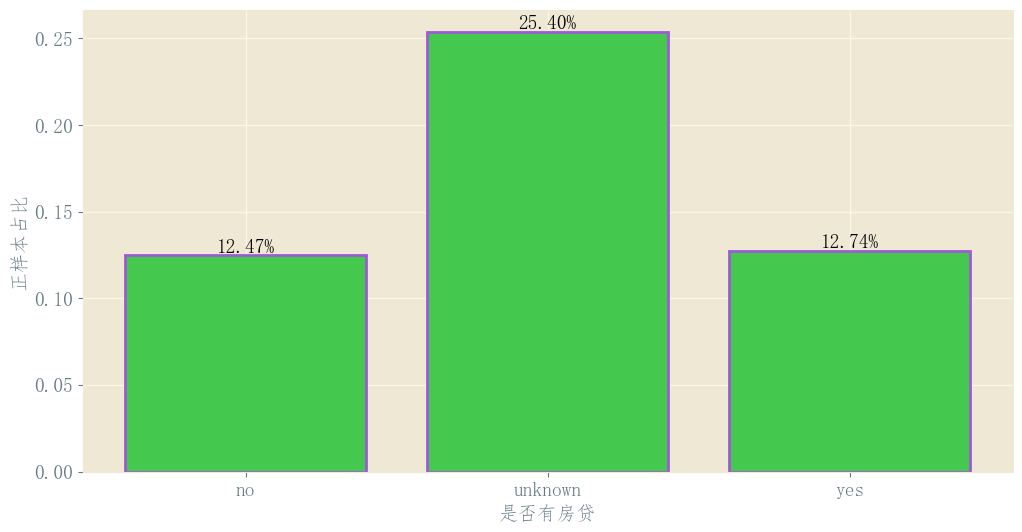

In [42]:
x, y = res['是否有房贷'].tolist(), res['正样本率'].tolist()
plt = bar_graph_plot(x, y, xlabel="是否有房贷", file="../figures/003_是否有房贷正样本分布.png", dpi=500, figsize=(12,6), rotation=0)
plt.show()

### 贷款分布

In [43]:
res = train.groupby(by='loan').agg(func={"id": "count", "LABEL": "sum"}).reset_index()
res.columns = ["是否有贷款", "样本数", "正样本数"]
res["正样本率"] = (res["正样本数"] / res["样本数"]).round(4)
res.sort_values(by='正样本率', ascending=False)

,是否有贷款,样本数,正样本数,正样本率
1,unknown,889,266,0.2992
2,yes,3657,517,0.1414
0,no,17954,2169,0.1208


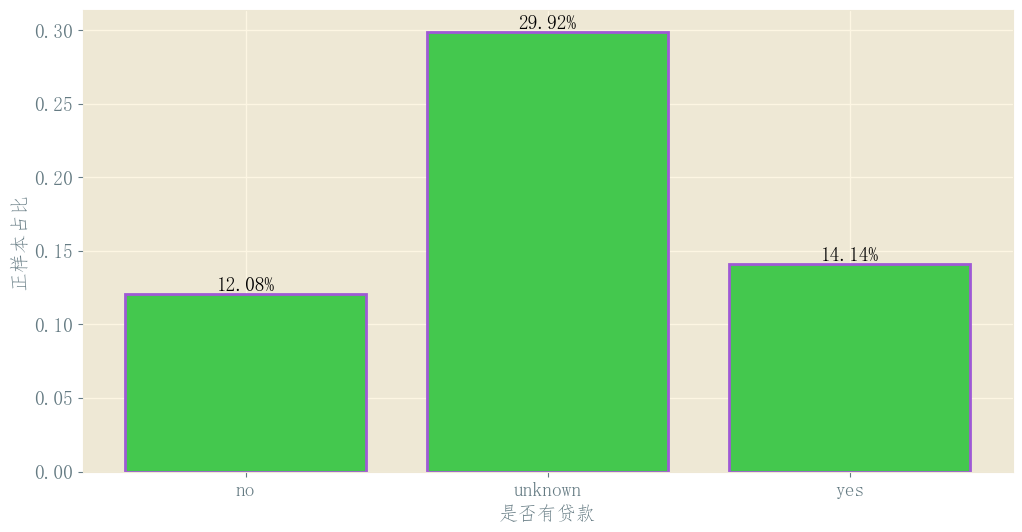

In [44]:
x, y = res['是否有贷款'].tolist(), res['正样本率'].tolist()
plt = bar_graph_plot(x, y, xlabel="是否有贷款", file="../figures/003_是否有贷款正样本分布.png", dpi=500, figsize=(12,6), rotation=0)
plt.show()

### 联系方式分布

In [45]:
res = train.groupby(by='contact').agg(func={"id": "count", "LABEL": "sum"}).reset_index()
res.columns = ["联系方式", "样本数", "正样本数"]
res["正样本率"] = (res["正样本数"] / res["样本数"]).round(4)
res.sort_values(by='正样本率', ascending=False)

,联系方式,样本数,正样本数,正样本率
0,cellular,14181,2298,0.1620
1,telephone,8319,654,0.0786


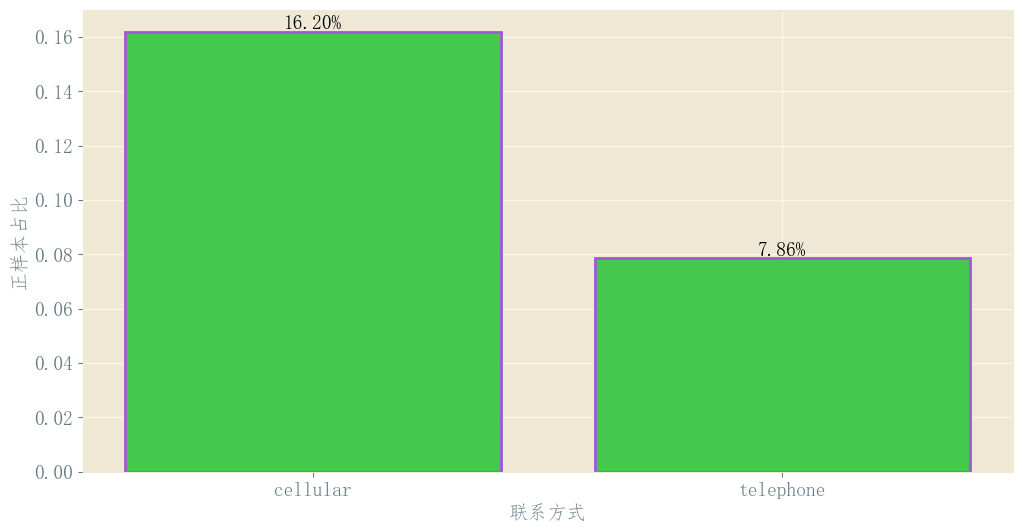

In [46]:
x, y = res['联系方式'].tolist(), res['正样本率'].tolist()
plt = bar_graph_plot(x, y, xlabel="联系方式", file="../figures/003_联系方式正样本分布.png", dpi=500, figsize=(12,6), rotation=0)
plt.show()

### 联系月份分布

In [47]:
res = train.groupby(by='month').agg(func={"id": "count", "LABEL": "sum"}).reset_index()
res.columns = ["联系月份", "样本数", "正样本数"]
res["正样本率"] = (res["正样本数"] / res["样本数"]).round(4)
res.sort_values(by='正样本率', ascending=False)

,联系月份,样本数,正样本数,正样本率
2,dec,199,103,0.5176
5,mar,426,215,0.5047
9,sep,401,196,0.4888
8,oct,494,227,0.4595
0,apr,1510,322,0.2132
4,jun,2838,340,0.1198
1,aug,3340,397,0.1189
7,nov,2242,254,0.1133
3,jul,3815,393,0.1030
6,may,7235,505,0.0698


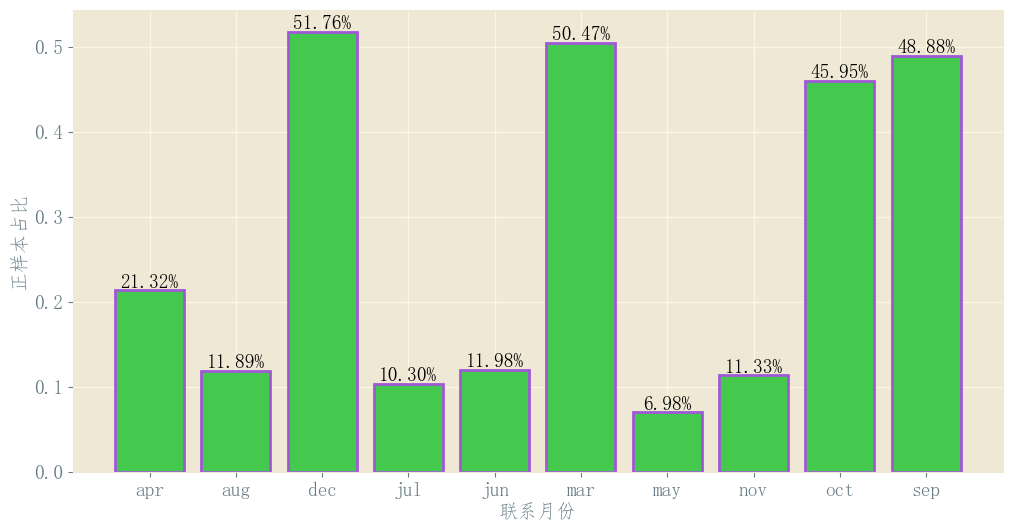

In [48]:
x, y = res['联系月份'].tolist(), res['正样本率'].tolist()
plt = bar_graph_plot(x, y, xlabel="联系月份", file="../figures/003_联系月份正样本分布.png", dpi=500, figsize=(12,6), rotation=0)
plt.show()

### 联系星期几

In [49]:
res = train.groupby(by='day_of_week').agg(func={"id": "count", "LABEL": "sum"}).reset_index()
res.columns = ["联系星期几", "样本数", "正样本数"]
res["正样本率"] = (res["正样本数"] / res["样本数"]).round(4)
res.sort_values(by='正样本率', ascending=False)

,联系星期几,样本数,正样本数,正样本率
3,tue,4414,629,0.1425
2,thu,4728,670,0.1417
4,wed,4458,588,0.1319
0,fri,4247,529,0.1246
1,mon,4653,536,0.1152


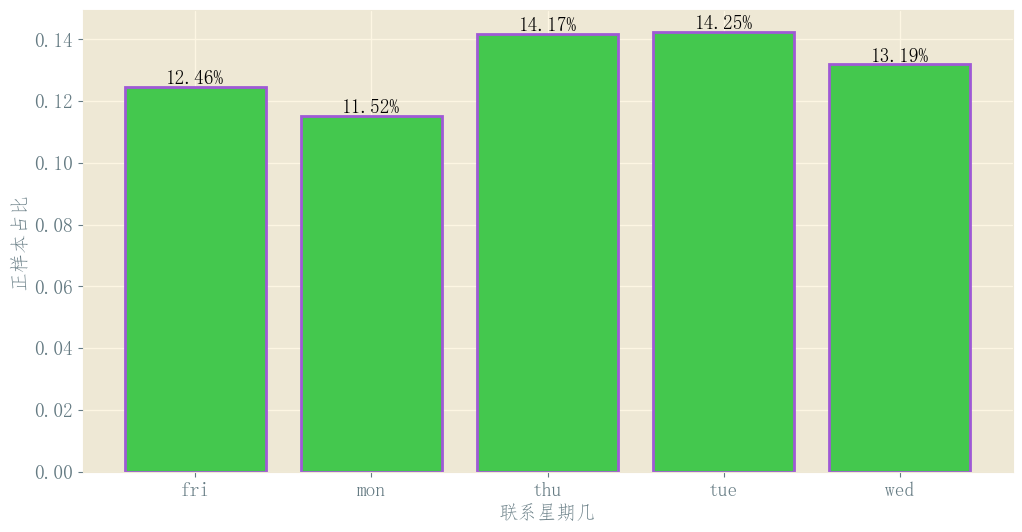

In [50]:
x, y = res['联系星期几'].tolist(), res['正样本率'].tolist()
plt = bar_graph_plot(x, y, xlabel="联系星期几", file="../figures/003_联系星期几正样本分布.png", dpi=500, figsize=(12,6), rotation=0)
plt.show()

### 营销结果分布

In [51]:
res = train.groupby(by='poutcome').agg(func={"id": "count", "LABEL": "sum"}).reset_index()
res.columns = ["营销结果", "样本数", "正样本数"]
res["正样本率"] = (res["正样本数"] / res["样本数"]).round(4)
res.sort_values(by='正样本率', ascending=False)

,营销结果,样本数,正样本数,正样本率
2,success,3440,683,0.1985
0,failure,4442,665,0.1497
1,nonexistent,14618,1604,0.1097


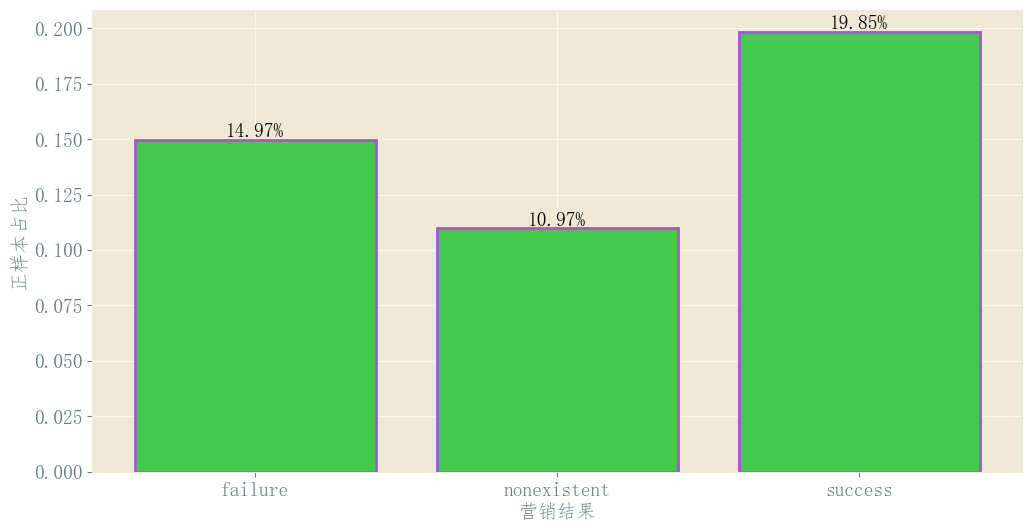

In [52]:
x, y = res['营销结果'].tolist(), res['正样本率'].tolist()
plt = bar_graph_plot(x, y, xlabel="营销结果", file="../figures/003_营销结果正样本分布.png", dpi=500, figsize=(12,6), rotation=0)
plt.show()

### 年龄分布

In [53]:
train["age_bin"] = pd.cut(train['age'], bins=10, right=False)
res = train.groupby(by='age_bin').agg(func={"id": "count", "LABEL": "sum"}).reset_index()
res.columns = ["年龄", "样本数", "正样本数"]
res["正样本率"] = (res["正样本数"] / res["样本数"]).round(4)
res["年龄"] = res["年龄"].astype(str)
res.sort_values(by='正样本率', ascending=False)

,年龄,样本数,正样本数,正样本率
7,"[75.5, 84.0)",182,93,0.5110
9,"[92.5, 101.085)",61,29,0.4754
8,"[84.0, 92.5)",162,77,0.4753
6,"[67.0, 75.5)",320,141,0.4406
5,"[58.5, 67.0)",647,202,0.3122
0,"[16.0, 24.5)",870,223,0.2563
1,"[24.5, 33.0)",5629,756,0.1343
4,"[50.0, 58.5)",3301,368,0.1115
2,"[33.0, 41.5)",7088,709,0.1000
3,"[41.5, 50.0)",4240,354,0.0835


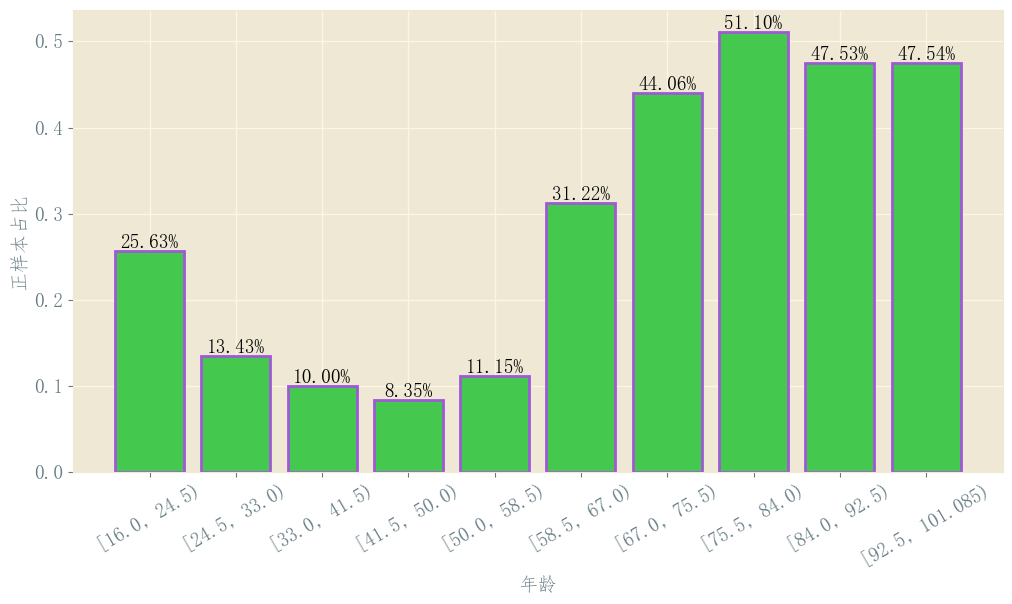

In [54]:
x, y = res['年龄'].tolist(), res['正样本率'].tolist()
plt = bar_graph_plot(x, y, xlabel="年龄", file="../figures/003_年龄正样本分布.png", dpi=500, figsize=(12,6), rotation=30)
plt.show()

### 联系时长分布

In [55]:
train["duration_bin"] = pd.cut(train['duration'], bins=6, right=False)
res = train.groupby(by='duration_bin').agg(func={"id": "count", "LABEL": "sum"}).reset_index()
res.columns = ["联系时长", "样本数", "正样本数"]
res["正样本率"] = (res["正样本数"] / res["样本数"]).round(4)
res["联系时长"] = res["联系时长"].astype(str)
res.sort_values(by='正样本率', ascending=False)

,联系时长,样本数,正样本数,正样本率
1,"[858.167, 1716.333)",1953,444,0.2273
2,"[1716.333, 2574.5)",1576,234,0.1485
5,"[4290.833, 5154.149)",1226,160,0.1305
4,"[3432.667, 4290.833)",1580,206,0.1304
3,"[2574.5, 3432.667)",1530,192,0.1255
0,"[0.0, 858.167)",14635,1716,0.1173


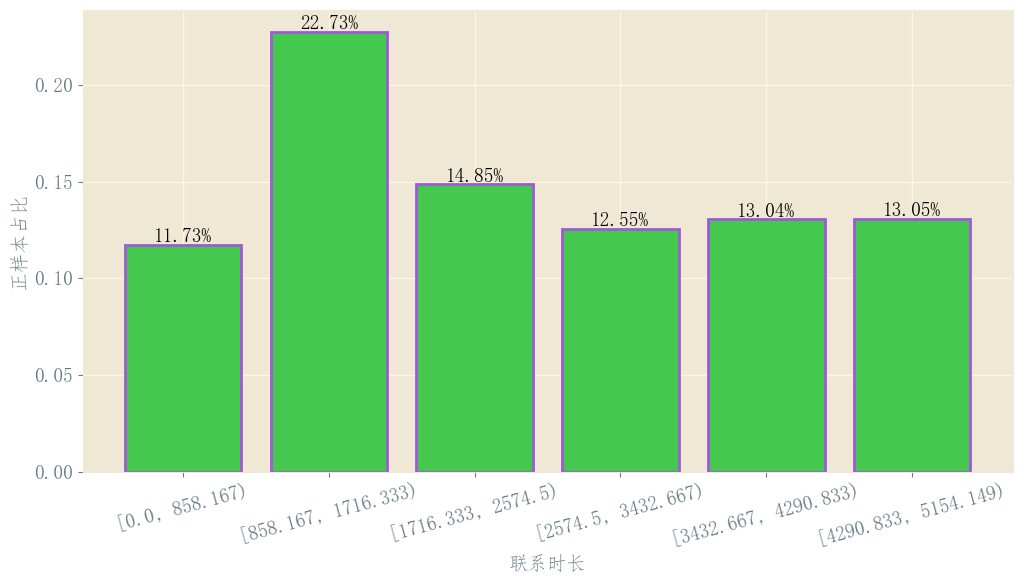

In [56]:
x, y = res['联系时长'].tolist(), res['正样本率'].tolist()
plt = bar_graph_plot(x, y, xlabel="联系时长", file="../figures/003_联系时长正样本分布.png", dpi=500, figsize=(12,6), rotation=15)
plt.show()

### 活动联系次数分布

In [57]:
train["campaign_bin"] = pd.cut(train['campaign'], bins=6, right=False)
res = train.groupby(by='campaign_bin').agg(func={"id": "count", "LABEL": "sum"}).reset_index()
res.columns = ["活动联系次数", "样本数", "正样本数"]
res["正样本率"] = (res["正样本数"] / res["样本数"]).round(4)
res["活动联系次数"] = res["活动联系次数"].astype(str)
res.sort_values(by='正样本率', ascending=False)

,活动联系次数,样本数,正样本数,正样本率
5,"[47.5, 57.057)",166,80,0.4819
3,"[28.5, 38.0)",214,99,0.4626
4,"[38.0, 47.5)",204,89,0.4363
2,"[19.0, 28.5)",279,99,0.3548
1,"[9.5, 19.0)",587,112,0.1908
0,"[0.0, 9.5)",21050,2473,0.1175


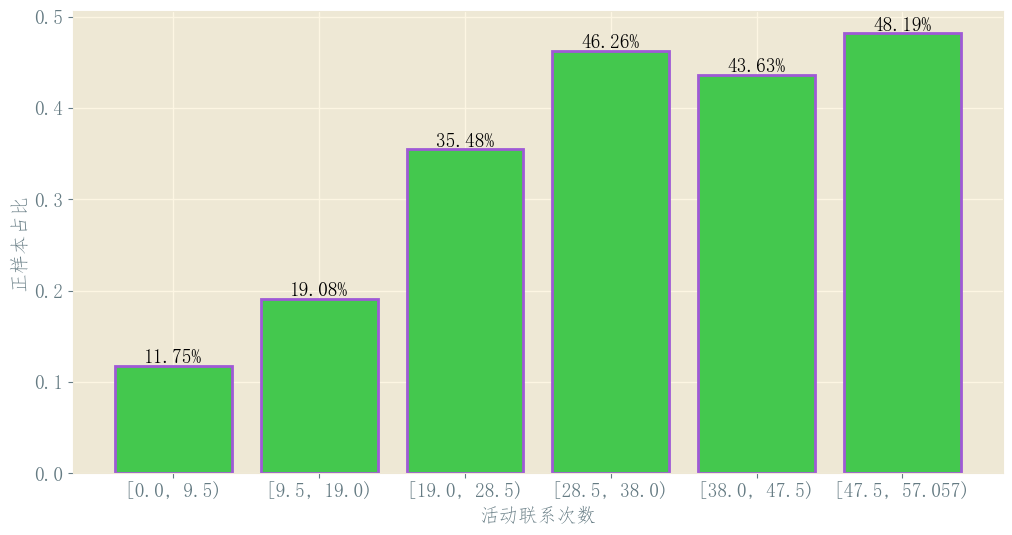

In [58]:
x, y = res['活动联系次数'].tolist(), res['正样本率'].tolist()
plt = bar_graph_plot(x, y, xlabel="活动联系次数", file="../figures/003_活动联系次数正样本分布.png", dpi=500, figsize=(12,6), rotation=0)
plt.show()

### 联系间隔天数分布

In [59]:
train["pdays_bin"] = pd.cut(train['pdays'], bins=6, right=False)
res = train.groupby(by='pdays_bin').agg(func={"id": "count", "LABEL": "sum"}).reset_index()
res.columns = ["联系间隔天数", "样本数", "正样本数"]
res["正样本率"] = (res["正样本数"] / res["样本数"]).round(4)
res["联系间隔天数"] = res["联系间隔天数"].astype(str)
res.sort_values(by='正样本率', ascending=False)

,联系间隔天数,样本数,正样本数,正样本率
0,"[0.0, 174.667)",2080,516,0.2481
2,"[349.333, 524.0)",1599,225,0.1407
3,"[524.0, 698.667)",1608,224,0.1393
4,"[698.667, 873.333)",1563,215,0.1376
1,"[174.667, 349.333)",1615,193,0.1195
5,"[873.333, 1049.048)",14035,1579,0.1125


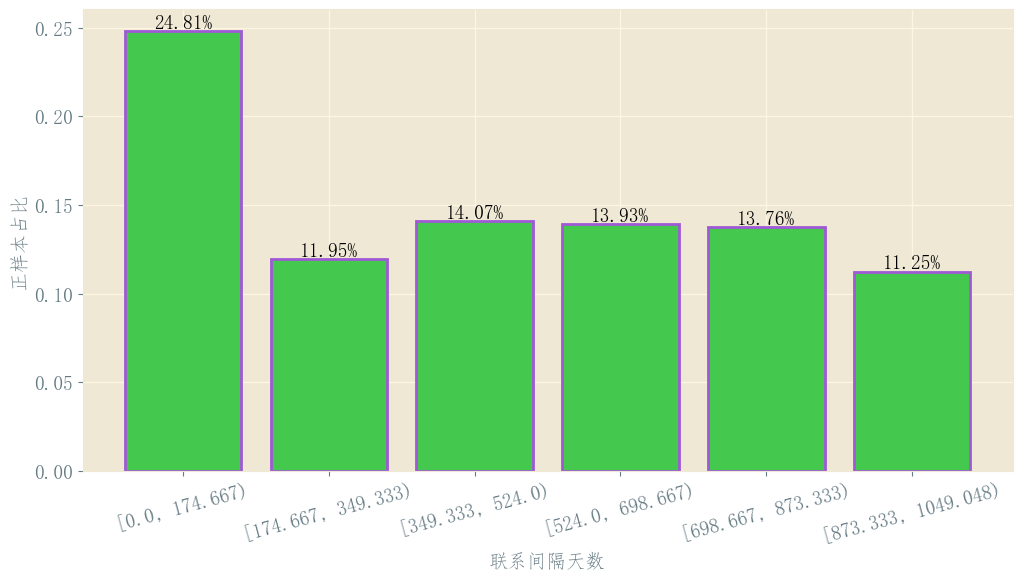

In [60]:
x, y = res['联系间隔天数'].tolist(), res['正样本率'].tolist()
plt = bar_graph_plot(x, y, xlabel="联系间隔天数", file="../figures/003_联系间隔天数正样本分布.png", dpi=500, figsize=(12,6), rotation=15)
plt.show()

### 客户联系次数分布

In [61]:
res = train.groupby(by='previous').agg(func={"id": "count", "LABEL": "sum"}).reset_index()
res.columns = ["客户联系次数", "样本数", "正样本数"]
res["正样本率"] = (res["正样本数"] / res["样本数"]).round(4)
res.sort_values(by='正样本率', ascending=False)

,客户联系次数,样本数,正样本数,正样本率
2,2,1539,297,0.1930
1,1,2750,528,0.1920
3,3,1410,209,0.1482
4,4,1323,186,0.1406
6,6,1285,172,0.1339
5,5,1312,168,0.1280
0,0,12881,1392,0.1081


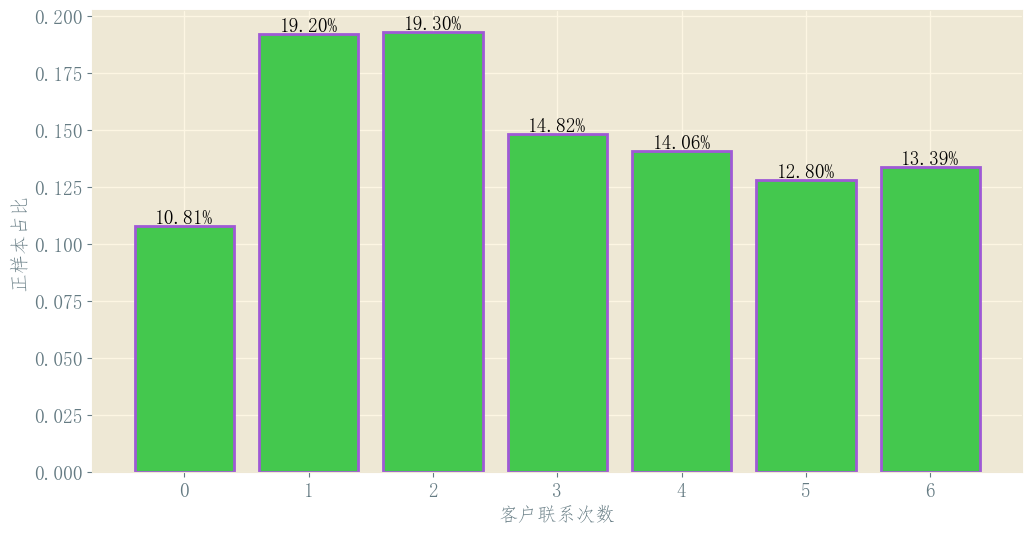

In [62]:
x, y = res['客户联系次数'].tolist(), res['正样本率'].tolist()
plt = bar_graph_plot(x, y, xlabel="客户联系次数", file="../figures/003_客户联系次数正样本分布.png", dpi=500, figsize=(12,6), rotation=0)
plt.show()

### 就业变动率分布

In [63]:
res = train.groupby(by='emp_var_rate').agg(func={"id": "count", "LABEL": "sum"}).reset_index()
res.columns = ["就业变动率", "样本数", "正样本数"]
res["正样本率"] = (res["正样本数"] / res["样本数"]).round(4)
res["就业变动率"] = res["就业变动率"].astype(str)
res.sort_values(by='正样本率', ascending=False)

,就业变动率,样本数,正样本数,正样本率
1,-3.0,93,51,0.5484
4,-1.7,420,223,0.5310
5,-1.1,344,175,0.5087
0,-3.4,601,257,0.4276
2,-2.9,920,337,0.3663
3,-1.8,5004,877,0.1753
9,1.4,8850,671,0.0758
7,-0.1,2020,153,0.0757
8,1.1,4245,208,0.0490
6,-0.2,3,0,0.0000


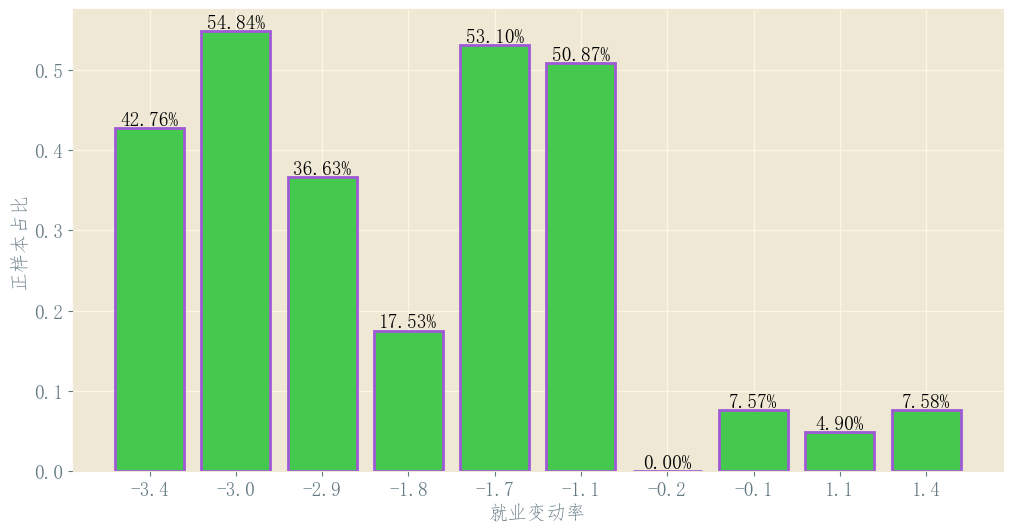

In [64]:
x, y = res['就业变动率'].tolist(), res['正样本率'].tolist()
plt = bar_graph_plot(x, y, xlabel="就业变动率", file="../figures/003_就业变动率正样本分布.png", dpi=500, figsize=(12,6), rotation=0)
plt.show()

### 价格指数分布

In [65]:
train["cons_price_index_bin"] = pd.cut(train['cons_price_index'], bins=6, right=False)
res = train.groupby(by='cons_price_index_bin').agg(func={"id": "count", "LABEL": "sum"}).reset_index()
res.columns = ["价格指数", "样本数", "正样本数"]
res["正样本率"] = (res["正样本数"] / res["样本数"]).round(4)
res["价格指数"] = res["价格指数"].astype(str)
res.sort_values(by='正样本率', ascending=False)

,价格指数,样本数,正样本数,正样本率
0,"[87.64, 89.61)",1928,311,0.1613
2,"[91.58, 93.55)",4666,605,0.1297
1,"[89.61, 91.58)",4667,603,0.1292
4,"[95.52, 97.49)",4645,599,0.1290
5,"[97.49, 99.472)",1925,245,0.1273
3,"[93.55, 95.52)",4669,589,0.1262


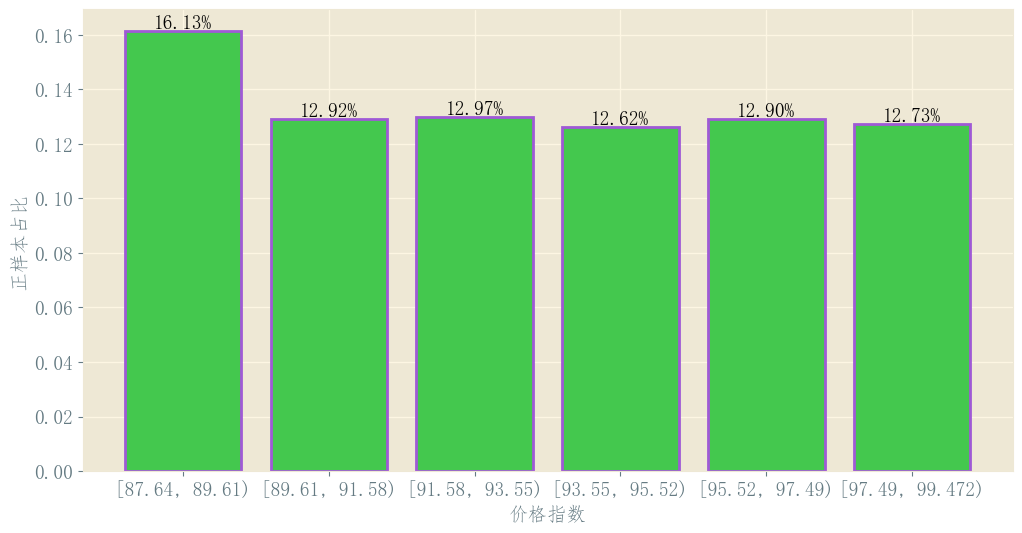

In [66]:
x, y = res['价格指数'].tolist(), res['正样本率'].tolist()
plt = bar_graph_plot(x, y, xlabel="价格指数", file="../figures/003_价格指数正样本分布.png", dpi=500, figsize=(12,6), rotation=0)
plt.show()

### 信心指数分布

In [67]:
train["cons_conf_index_bin"] = pd.cut(train['cons_conf_index'], bins=6, right=False)
res = train.groupby(by='cons_conf_index_bin').agg(func={"id": "count", "LABEL": "sum"}).reset_index()
res.columns = ["信心指数", "样本数", "正样本数"]
res["正样本率"] = (res["正样本数"] / res["样本数"]).round(4)
res["信心指数"] = res["信心指数"].astype(str)
res.sort_values(by='正样本率', ascending=False)

,信心指数,样本数,正样本数,正样本率
5,"[-30.172, -25.522)",1513,292,0.1930
0,"[-53.28, -48.658)",1083,198,0.1828
4,"[-34.793, -30.172)",2580,458,0.1775
1,"[-48.658, -44.037)",4717,622,0.1319
2,"[-44.037, -39.415)",6633,735,0.1108
3,"[-39.415, -34.793)",5974,647,0.1083


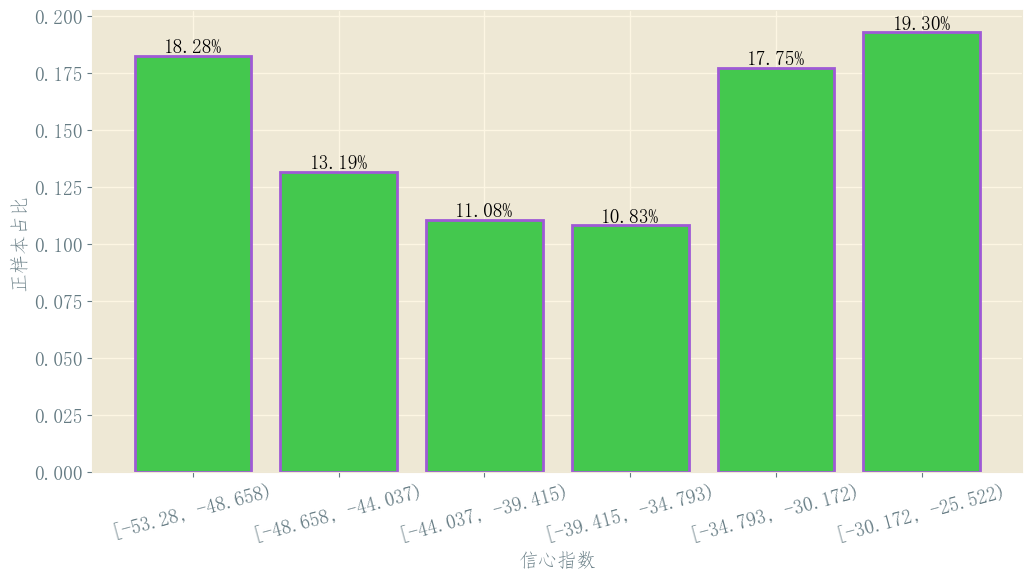

In [68]:
x, y = res['信心指数'].tolist(), res['正样本率'].tolist()
plt = bar_graph_plot(x, y, xlabel="信心指数", file="../figures/003_信心指数正样本分布.png", dpi=500, figsize=(12,6), rotation=15)
plt.show()

### 银行同业拆借率3个月利率分布

In [69]:
train["lending_rate3m_bin"] = pd.cut(train['lending_rate3m'], bins=6, right=False)
res = train.groupby(by='lending_rate3m_bin').agg(func={"id": "count", "LABEL": "sum"}).reset_index()
res.columns = ["银行同业拆借率", "样本数", "正样本数"]
res["正样本率"] = (res["正样本数"] / res["样本数"]).round(4)
res["银行同业拆借率"] = res["银行同业拆借率"].astype(str)
res.sort_values(by='正样本率', ascending=False)

,银行同业拆借率,样本数,正样本数,正样本率
0,"[0.6, 1.378)",5126,1192,0.2325
1,"[1.378, 2.157)",2427,372,0.1533
3,"[2.935, 3.713)",1589,212,0.1334
2,"[2.157, 2.935)",1584,196,0.1237
4,"[3.713, 4.492)",2841,302,0.1063
5,"[4.492, 5.275)",8933,678,0.0759


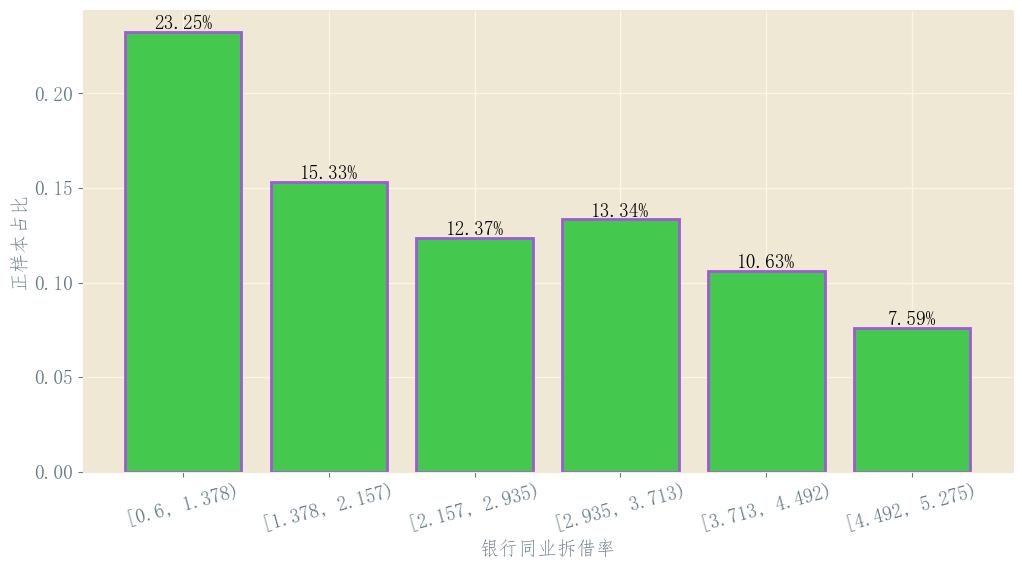

In [70]:
x, y = res['银行同业拆借率'].tolist(), res['正样本率'].tolist()
plt = bar_graph_plot(x, y, xlabel="银行同业拆借率", file="../figures/003_银行同业拆借率正样本分布.png", dpi=500, figsize=(12,6), rotation=15)
plt.show()

### 雇员人数分布

In [71]:
train["nr_employed_bin"] = pd.cut(train['nr_employed'], bins=6, right=False)
res = train.groupby(by='nr_employed_bin').agg(func={"id": "count", "LABEL": "sum"}).reset_index()
res.columns = ["雇员人数", "样本数", "正样本数"]
res["正样本率"] = (res["正样本数"] / res["样本数"]).round(4)
res["雇员人数"] = res["雇员人数"].astype(str)
res.sort_values(by='正样本率', ascending=False)

,雇员人数,样本数,正样本数,正样本率
0,"[4715.42, 4844.433)",873,202,0.2314
1,"[4844.433, 4973.447)",3247,536,0.1651
3,"[5102.46, 5231.473)",5538,736,0.1329
2,"[4973.447, 5102.46)",5747,757,0.1317
4,"[5231.473, 5360.487)",4523,529,0.1170
5,"[5360.487, 5490.274)",2572,192,0.0747


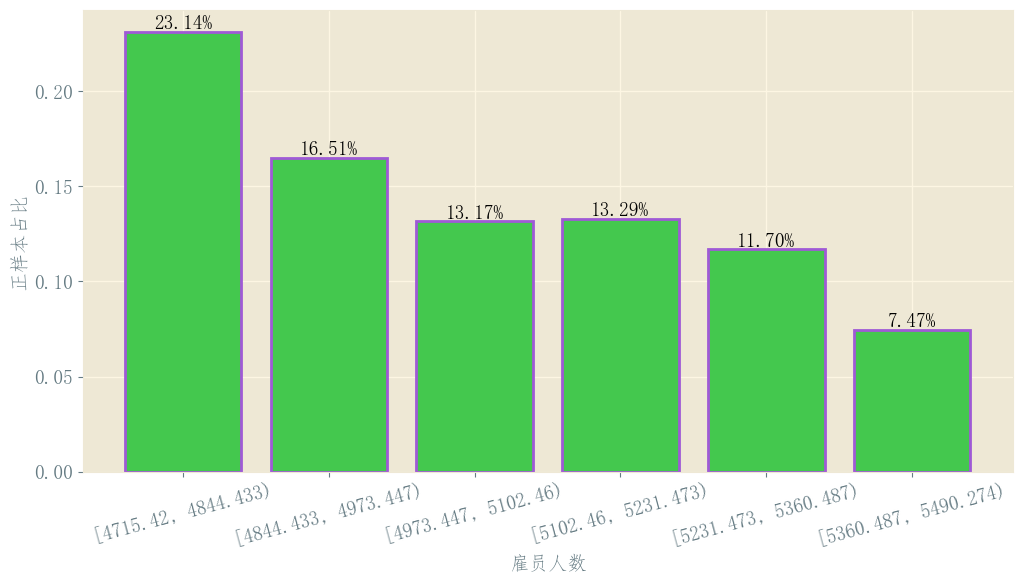

In [72]:
x, y = res['雇员人数'].tolist(), res['正样本率'].tolist()
plt = bar_graph_plot(x, y, xlabel="雇员人数", file="../figures/003_雇员人数正样本分布.png", dpi=500, figsize=(12,6), rotation=15)
plt.show()

# 管道训练

- 树模型不需要进行特殊的特征工程，树模型能够自动捕捉非线性关系。  
- 树模型不需要进行标准化，对特征的尺度和数值范围不敏感。  

## 删除无关字段

In [74]:
del_colnames = ['id', 'subscribe']
for colname in train.columns.tolist():
    if '_bin' in colname:
        del_colnames.append(colname)
        
train.drop(del_colnames, axis=1, inplace=True)

## 定义数据集

In [87]:
X, y = train.iloc[:, :-1], train['LABEL']

## 定义管道

In [88]:
# 列出需要标准化的数值型特征和需要独热编码的类别型特征
numeric_features = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp_var_rate', 
                    'cons_price_index', 'cons_conf_index', 'lending_rate3m', 'nr_employed']
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
# 定义ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),  # 标准化数值型特征
        ('cat', OneHotEncoder(), categorical_features)  # 独热编码类别型特征
    ])

# 定义包含数据处理和特征工程的Pipeline
preprocessing_pipeline = Pipeline([
    ('preprocessor', preprocessor)  # 数据处理和特征工程
])

# 在训练集上拟合数据处理和特征工程的Pipeline
X_transformed = preprocessing_pipeline.fit_transform(X)

## 贝叶斯搜索

In [109]:
%%time
# 定义参数搜索范围
param_space = {
    'num_leaves': (5, 50),
    'max_depth': (3, 15),
    'learning_rate': (0.01, 0.2, 'log-uniform'),
    'n_estimators': (50, 200),
    'subsample_for_bin': (20000, 300000),
    'class_weight_ratio': (1, 10),
    'min_split_gain': (0.0, 1.0),
    'min_child_weight': (0.5, 10),
    'min_child_samples': (5, 20),
    'subsample': (0.5, 1.0),
    'subsample_freq': (1, 10),
    'colsample_bytree': (0.5, 1.0),
    'reg_alpha': (0.0, 1.0),
    'reg_lambda': (0.0, 1.0),
    'importance_type': ['split', 'gain']
}

lgbm_model = LGBMClassifier(boosting_type="gbdt", objective="binary", random_state=12)

def objective_function(params):
    # 将权重比例转换为字典形式
    class_weight = {0: 1, 1: params['class_weight_ratio']}
    params.pop('class_weight_ratio')  # 从参数中移除权重比例
    lgbm_model.set_params(class_weight=class_weight, **params)
    return -np.mean(cross_val_score(lgbm_model, X_transformed, y, cv=5, scoring='accuracy'))

# 使用BayesSearchCV进行贝叶斯调参
bayes_search = BayesSearchCV(
    lgbm_model,
    param_space,
    n_iter=50,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

# 执行贝叶斯搜索
bayes_search.fit(X_transformed, y)

# 输出最佳参数
print("Best parameters found: ", bayes_search.best_params_)

# 输出最佳交叉验证分数
print("Best cross-validation score: {:.4f}".format(-bayes_search.best_score_))

Best parameters found:  OrderedDict([('class_weight_ratio', 9), ('colsample_bytree', 0.5), ('importance_type', 'gain'), ('learning_rate', 0.03015043267772244), ('max_depth', 13), ('min_child_samples', 5), ('min_child_weight', 0.5), ('min_split_gain', 1.0), ('n_estimators', 141), ('num_leaves', 40), ('reg_alpha', 0.7983328616849275), ('reg_lambda', 0.476276955000648), ('subsample', 0.9400481680960349), ('subsample_for_bin', 20000), ('subsample_freq', 5)])
Best cross-validation score: -0.8928
CPU times: total: 3min 57s
Wall time: 1min 39s


## 训练模型

In [116]:
# 划分训练集与验证集
x_train, x_valid, y_train, y_valid = train_test_split(X_transformed, y, test_size=0.3, random_state=12)

# 得到贝叶斯搜索得到的最佳参数
best_params = bayes_search.best_params_

# 将最佳参数设置到LightGBM模型中
lgbm_model.set_params(**best_params)

# 训练模型
lgbm_model.fit(x_train, y_train, 
               eval_set=[(x_train, y_train), (x_valid, y_valid)], 
               eval_metric=['logloss', 'auc'], 
               early_stopping_rounds=10)

[1]	training's binary_logloss: 0.384261	training's auc: 0.815075	valid_1's binary_logloss: 0.380921	valid_1's auc: 0.791431
[2]	training's binary_logloss: 0.376025	training's auc: 0.890028	valid_1's binary_logloss: 0.373199	valid_1's auc: 0.871442
[3]	training's binary_logloss: 0.371587	training's auc: 0.895593	valid_1's binary_logloss: 0.369455	valid_1's auc: 0.873472
[4]	training's binary_logloss: 0.364638	training's auc: 0.899452	valid_1's binary_logloss: 0.362968	valid_1's auc: 0.879169
[5]	training's binary_logloss: 0.361174	training's auc: 0.900199	valid_1's binary_logloss: 0.359941	valid_1's auc: 0.879133
[6]	training's binary_logloss: 0.357701	training's auc: 0.899222	valid_1's binary_logloss: 0.35679	valid_1's auc: 0.88005
[7]	training's binary_logloss: 0.351748	training's auc: 0.901599	valid_1's binary_logloss: 0.351389	valid_1's auc: 0.882905
[8]	training's binary_logloss: 0.347126	training's auc: 0.903044	valid_1's binary_logloss: 0.347247	valid_1's auc: 0.884466
[9]	traini

LGBMClassifier(class_weight_ratio=9, colsample_bytree=0.5,
               importance_type='gain', learning_rate=0.03015043267772244,
               max_depth=13, min_child_samples=5, min_child_weight=0.5,
               min_split_gain=1.0, n_estimators=141, num_leaves=40,
               objective='binary', random_state=12,
               reg_alpha=0.7983328616849275, reg_lambda=0.476276955000648,
               subsample=0.9400481680960349, subsample_for_bin=20000,
               subsample_freq=5)

# 使用模型

模型得分：0.9224

In [120]:
test = pd.read_csv("../dataset/test.csv")
use_test = test.iloc[:, 1:]

test_transformed = preprocessing_pipeline.transform(use_test)
test["subscribe"] = lgbm_model.predict(test_transformed)
test["subscribe"] = test["subscribe"].apply(lambda x: "yes" if x == 1 else "no")

test[["id", "subscribe"]].to_csv("../results/submission.csv", index=False)